In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import yaml
import re
import glob
import timm
import torch
import torch as th
import torch.nn as nn
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from horama import maco, plot_maco
from sklearn.metrics.pairwise import cosine_similarity
from core.posthoc_prediction_utils import find_sort_png_files_by_subfolder, parse_accentuated_filename, parse_accentuated_filenames_to_df 
from core.posthoc_prediction_utils import get_PCA_basis_predictor_from_config, get_predictor_from_config, get_unit_population_PCA_basis_predictor_from_config, get_prediction_responses


In [ ]:

acc_stim_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs"
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
    
for subject_id, filename in [
    ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    ("paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5"),
    ("three0_250426-250501", "three0_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    ("leap_250426-250501", "leap_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
]:
    posthoc_PCA_dir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/{subject_id}/posthoc_model_predict_PCA_popul_unit"
    os.makedirs(posthoc_PCA_dir, exist_ok=True)
    # config_files
    target_subfolder = glob.glob(join(acc_stim_root, f"*{subject_id}*_accentuation"))
    all_png_files = find_sort_png_files_by_subfolder(target_subfolder)
    png_files_list = sum(all_png_files.values(), [])
    df_accentuated = parse_accentuated_filenames_to_df(png_files_list)
    df_accentuated.to_pickle(join(posthoc_PCA_dir, f"df_accentuated_{subject_id}.pkl"))
    config_dir = join(config_root, subject_id)
    config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
    # chan_pattern = "_Ch19_"
    # config_pre_chan = [f for f in config_files if chan_pattern in f]
    # cosine_results = []
    for config_file in config_files:
        config_acc = yaml.load(open(config_file, "r"), Loader=yaml.FullLoader)
        model_name = config_acc["model_name"]
        unit_id = config_acc["unit_ids"][0]
        layer_name = config_acc["layer_name"]
        print(f"Subject: {subject_id}, Unit: {unit_id}, Model: {model_name}, Layer: {layer_name}")
        acc_split_df = df_accentuated.copy()
        # acc_split_df = df_accentuated.query("model_name == @model_name and unit_id == @unit_id")
        # assert len (acc_split_df) == 110 

        predict_PCA_feature, predict_population_response, predict_target_unit_response, \
            model, transforms_pipeline, fetcher, Xtransform, readout \
                = get_unit_population_PCA_basis_predictor_from_config(config_file, device="cuda")
        # accentuated_dataset = ImagePathDataset(acc_split_df["filepath"], transform=transforms_pipeline)
        # accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=60, shuffle=False, num_workers=10)
        acc_img_PCA_resp = get_prediction_responses(predict_PCA_feature, transforms_pipeline, 
                                            acc_split_df["filepath"].tolist(), batch_size=120, num_workers=16)
        acc_img_population_resp = get_prediction_responses(predict_population_response, transforms_pipeline, 
                                            acc_split_df["filepath"].tolist(), batch_size=120, num_workers=16)
        acc_model_target_unit_resp = get_prediction_responses(predict_target_unit_response, transforms_pipeline, 
                                            acc_split_df["filepath"].tolist(), batch_size=120, num_workers=16)
        readout_vec = readout.weight.data[unit_id, :].cpu()
        readout_bias = readout.bias.data[unit_id].cpu()
        PCA_norm = acc_img_PCA_resp.norm(dim=1)
        cosine_sims = cosine_similarity(acc_img_PCA_resp.cpu().numpy(), readout_vec.numpy().reshape(1, -1))
        cosine_sims = cosine_sims.flatten() 
        acc_split_df_cos = acc_split_df.copy()
        acc_split_df_cos["cosine_similarity"] = cosine_sims
        acc_split_df_cos["PCA_norm"] = PCA_norm
        
        print(f"Min cosine similarity: {cosine_sims.min():.4f}")
        print(f"Max cosine similarity: {cosine_sims.max():.4f}")
        print(f"PCA norm max {PCA_norm.max():.4f}")
        print(f"PCA norm min {PCA_norm.min():.4f}")
        
        stats_dict = {"config": config_acc, 
                            "df": acc_split_df_cos.copy(), 
                            "PCA_resp": acc_img_PCA_resp, 
                            "population_resp": acc_img_population_resp,
                            "target_unit_resp": acc_model_target_unit_resp,
                            "readout_vec": readout_vec, 
                            "readout_bias": readout_bias,
                            "cosine_sims": cosine_sims, 
                            "PCA_norm": PCA_norm}
        pkl.dump(stats_dict, open(join(posthoc_PCA_dir, f"posthoc_prediction_PCA_pop_unit_{subject_id}_unit{unit_id}_{model_name}.pkl"), "wb"))
        print(f"Saved to {join(posthoc_PCA_dir, f'posthoc_prediction_PCA_pop_unit_{subject_id}_unit{unit_id}_{model_name}.pkl')} completed!")

        

### Recompute synopsis

In [ ]:
for subject_id, filename in [
    ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("three0_250426-250501", "three0_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("leap_250426-250501", "leap_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
]:
    posthoc_PCA_dir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/{subject_id}/posthoc_model_predict_PCA_popul_unit"
    all_pkl_files = glob.glob(join(posthoc_PCA_dir, "posthoc_prediction_PCA_pop_unit_*.pkl"))
    for pkl_file in all_pkl_files:
        stats_dict = pkl.load(open(pkl_file, "rb"))
        print(f"{subject_id}: unit {stats_dict['config']['unit_ids']},  {stats_dict['config']['model_name']}, layer {stats_dict['config']['layer_name']}")

red_20250428-20250430: unit [0],  AlexNet_training_seed_01, layer .features.MaxPool2d12
red_20250428-20250430: unit [0],  clipag_vitb32, layer .transformer.resblocks.ResidualAttentionBlock8
red_20250428-20250430: unit [0],  dinov2_vitb14_reg, layer .blocks.NestedTensorBlock8
red_20250428-20250430: unit [0],  radio_v2.5-b, layer .model.blocks.Block10
red_20250428-20250430: unit [0],  regnety_640, layer .s3.Bottleneckb9
red_20250428-20250430: unit [0],  resnet50, layer .layer4.Bottleneck0
red_20250428-20250430: unit [0],  resnet50_clip, layer .layer4.Bottleneck0
red_20250428-20250430: unit [0],  resnet50_dino, layer .layer4.Bottleneck0
red_20250428-20250430: unit [0],  resnet50_robust, layer .layer4.Bottleneck1
red_20250428-20250430: unit [0],  siglip2_vitb16, layer .trunk.blocks.Block11
red_20250428-20250430: unit [15],  AlexNet_training_seed_01, layer .features.MaxPool2d12
red_20250428-20250430: unit [15],  clipag_vitb32, layer .transformer.resblocks.ResidualAttentionBlock6
red_2025042

In [8]:
list(stats_dict)

['config',
 'df',
 'PCA_resp',
 'population_resp',
 'target_unit_resp',
 'readout_vec',
 'readout_bias',
 'cosine_sims',
 'PCA_norm']

In [9]:
stats_dict["cosine_sims"].shape

(5500,)

In [11]:
model_name = stats_dict["config"]["model_name"]
unit_id = stats_dict["config"]["unit_ids"][0]
acc_unit_df = stats_dict["df"].query("model_name == @model_name and unit_id == @unit_id")
acc_unit_df.head()
acc_unit_df.shape

model_name  unit_id  img_id     level     score  \
0     AlexNet_training_seed_01        0       0 -0.228237 -0.221289   
1     AlexNet_training_seed_01        0       0 -1.037346 -1.027856   
2     AlexNet_training_seed_01        0       0 -1.846455 -1.838532   
3     AlexNet_training_seed_01        0       0  0.580873  0.572135   
4     AlexNet_training_seed_01        0       0  1.389982  1.380919   
...                        ...      ...     ...       ...       ...   
5495            siglip2_vitb16        9       9  2.701443  2.691693   
5496            siglip2_vitb16        9       9  3.442825  3.434636   
5497            siglip2_vitb16        9       9  4.184206  4.180340   
5498            siglip2_vitb16        9       9  4.925587  4.921776   
5499            siglip2_vitb16        9       9  5.666968  5.657128   

                                               filepath  cosine_similarity  \
0     /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.063252   
1     /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.077263   
2     /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.074851   
3     /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.062683   
4     /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.067422   
...                                                 ...                ...   
5495  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.372914   
5496  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.334410   
5497  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.351162   
5498  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.398769   
5499  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.398811   

        PCA_norm  
0     117.050270  
1     119.660774  
2     134.727386  
3     116.555077  
4     114.257751  
...          ...  
5495  156.940796  
5496  223.632507  
5497  259.075104  
5498  269.788849  
5499  310.018372  

[5500 rows x 8 columns]

In [12]:

model_name = stats_dict["config"]["model_name"]
unit_id = stats_dict["config"]["unit_ids"][0]
acc_unit_df = stats_dict["df"].query("model_name == @model_name and unit_id == @unit_id")

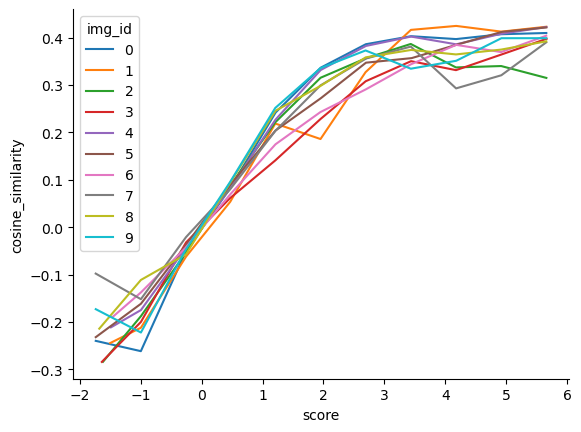

In [15]:
sns.lineplot(x="score", y="cosine_similarity", data=acc_unit_df, hue="img_id", palette="tab10", markers=True)
plt.show()

In [ ]:
for subject_id, filename in [
    ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("three0_250426-250501", "three0_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("leap_250426-250501", "leap_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
]:
    posthoc_PCA_dir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/{subject_id}/posthoc_model_predict_PCA_popul_unit"
    all_pkl_files = glob.glob(join(posthoc_PCA_dir, "posthoc_prediction_PCA_pop_unit_*.pkl"))
    for pkl_file in all_pkl_files:
        stats_dict = pkl.load(open(pkl_file, "rb"))
        model_name = stats_dict["config"]["model_name"]
        unit_id = stats_dict["config"]["unit_ids"][0]
        acc_unit_df = stats_dict["df"].query("model_name == @model_name and unit_id == @unit_id")
        cosine_sims_acc = stats_dict["cosine_sims"][acc_unit_df.index]

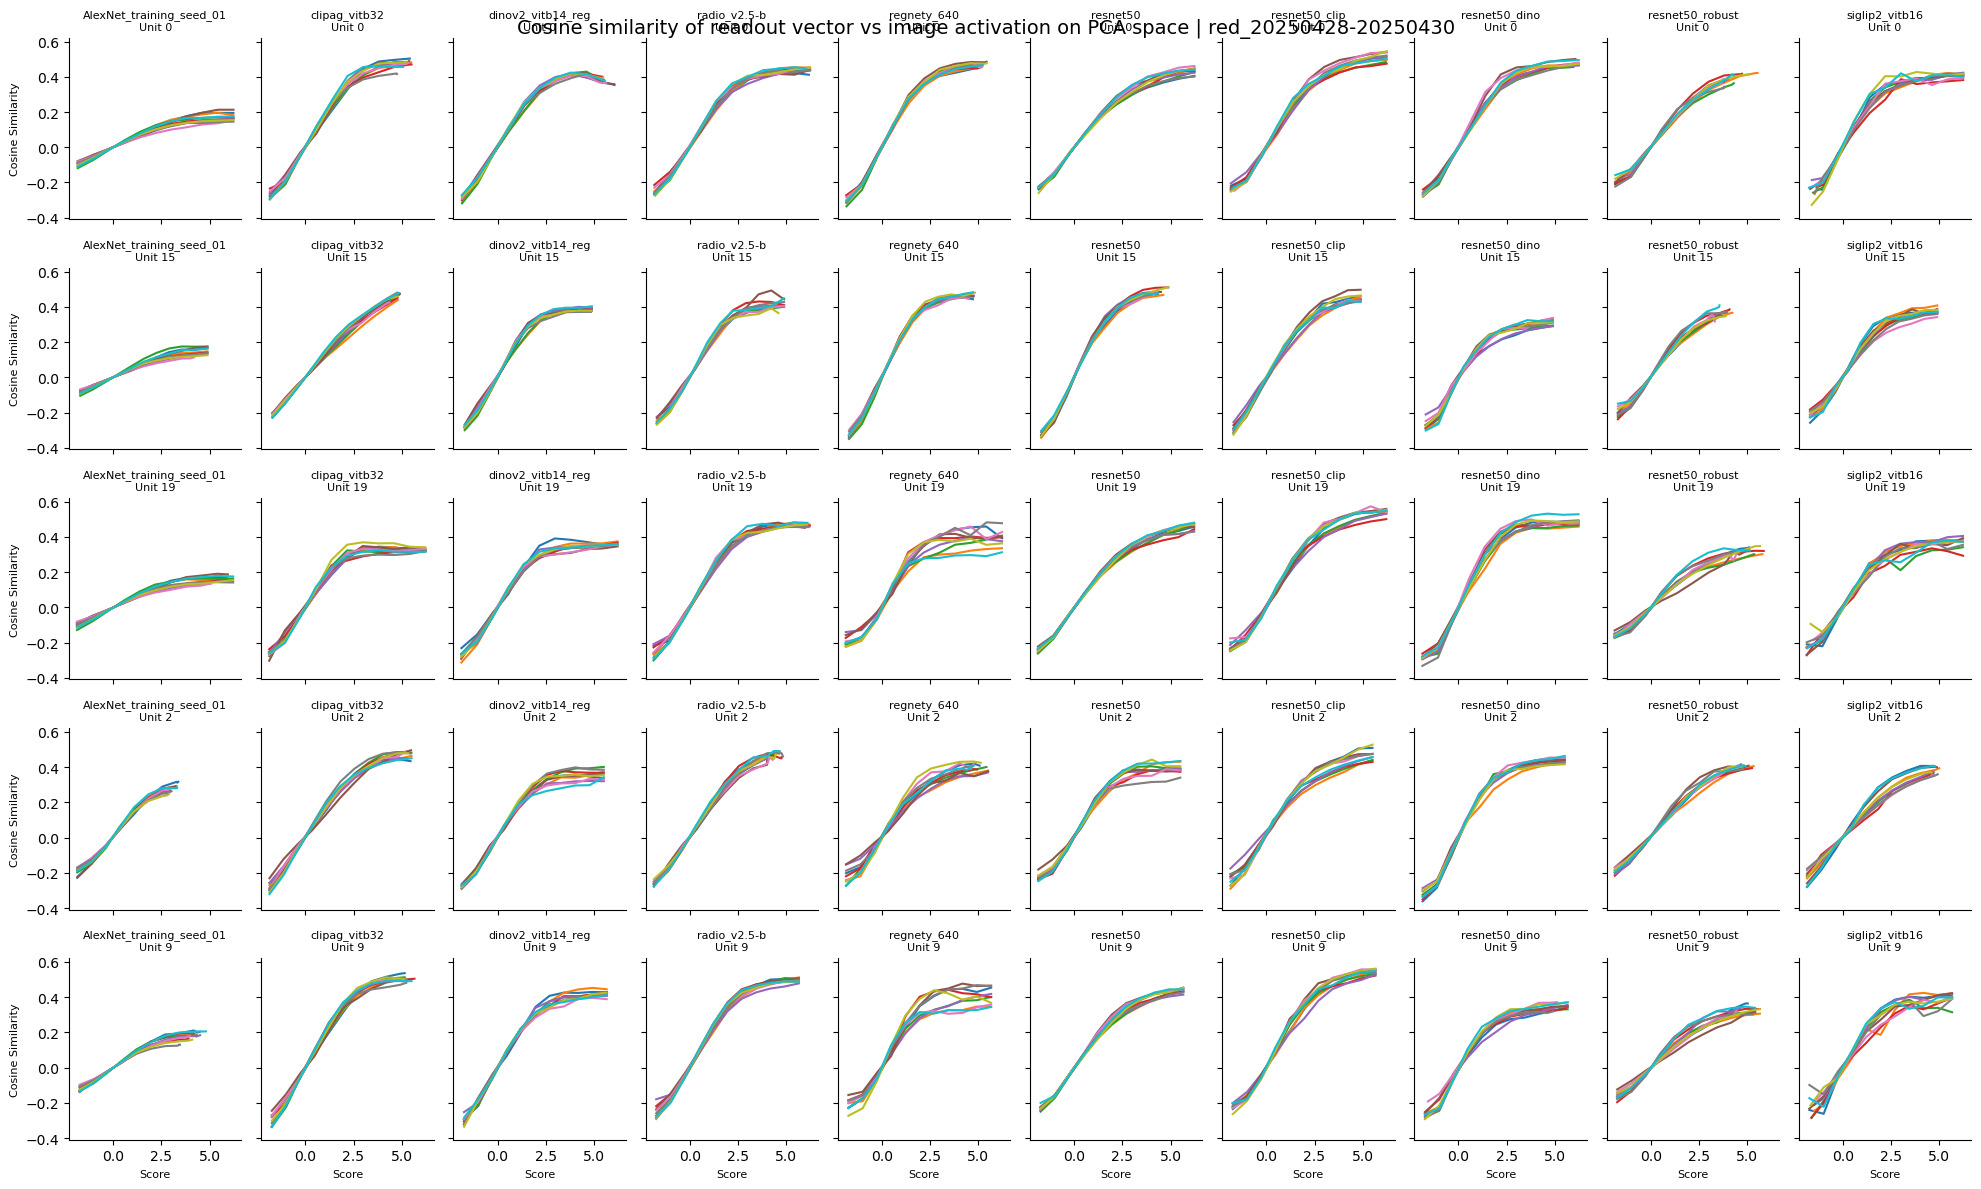

In [ ]:
# Create a multi-panel plot with 5 rows (units) and 10 columns (models)
fig, axes = plt.subplots(5, 10, figsize=(20, 12), sharex=True, sharey=True)
for subject_id, filename in [
    ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("three0_250426-250501", "three0_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("leap_250426-250501", "leap_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
]:
    posthoc_PCA_dir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/{subject_id}/posthoc_model_predict_PCA_popul_unit"
    all_pkl_files = glob.glob(join(posthoc_PCA_dir, "posthoc_prediction_PCA_pop_unit_*.pkl"))
    # Get unique model names and unit IDs for indexing
    model_names = []
    unit_ids = []
    for pkl_file in all_pkl_files:
        stats_dict = pkl.load(open(pkl_file, "rb"))
        model_name = stats_dict["config"]["model_name"]
        unit_id = stats_dict["config"]["unit_ids"][0]
        if model_name not in model_names:
            model_names.append(model_name)
        if unit_id not in unit_ids:
            unit_ids.append(unit_id)
    
    for pkl_file in all_pkl_files:
        stats_dict = pkl.load(open(pkl_file, "rb"))
        model_name = stats_dict["config"]["model_name"]
        unit_id = stats_dict["config"]["unit_ids"][0]
        acc_unit_df = stats_dict["df"].query("model_name == @model_name and unit_id == @unit_id")
        # Find row and column indices
        row_idx = unit_ids.index(unit_id)
        col_idx = model_names.index(model_name)
        
        if row_idx < 5 and col_idx < 10:
            sns.lineplot(x="score", y="cosine_similarity", data=acc_unit_df, hue="img_id", 
                        palette="tab10", markers=True, ax=axes[row_idx, col_idx], legend=False)
            axes[row_idx, col_idx].set_title(f"{model_name}\nUnit {unit_id}", fontsize=8)
            axes[row_idx, col_idx].set_xlabel("Score", fontsize=8)
            axes[row_idx, col_idx].set_ylabel("Cosine Similarity", fontsize=8)

# Hide any unused subplots
for row in range(5):
    for col in range(10):
        if not axes[row, col].has_data():
            axes[row, col].set_visible(False)

plt.suptitle(f"Cosine similarity of readout vector vs image activation on PCA space | {subject_id} | color by seed id", fontsize=14)
plt.tight_layout()
plt.show()

### Computing stats with changing PC cutoff 

In [20]:
# Create a dictionary to index stats_dict by (model_name, unit_id)
stats_dict_index = {}
for pkl_file in all_pkl_files:
    stats_dict = pkl.load(open(pkl_file, "rb"))
    model_name = stats_dict["config"]["model_name"]
    unit_id = stats_dict["config"]["unit_ids"][0]
    # Index the stats_dict
    stats_dict_index[(model_name, unit_id)] = stats_dict

In [21]:
model_names = set([model_name for model_name, _ in stats_dict_index.keys()])
unit_ids = set([unit_id for _, unit_id in stats_dict_index.keys()])

In [22]:
stats_dict["PCA_resp"].shape

torch.Size([5500, 750])

In [23]:
stats_dict["readout_vec"].shape

torch.Size([750])

In [24]:
import torch.nn.functional as F
F.cosine_similarity(stats_dict["PCA_resp"], 
                    stats_dict["readout_vec"].unsqueeze(0), dim=1)

tensor([0.0633, 0.0773, 0.0749,  ..., 0.3512, 0.3988, 0.3988])

In [26]:
# Compute cosine similarity between readout vector and PCA responses with varying PC cutoffs
pc_cutoffs = [2,3,5,*range(10, 751, 10)]  # From 10 to 750 PCs in steps of 10
cosine_results = {}

for model_name, unit_id in stats_dict_index.keys():
    stats_dict = stats_dict_index[(model_name, unit_id)]
    readout_vec = stats_dict["readout_vec"].to("cuda")
    PCA_resp = stats_dict["PCA_resp"].to("cuda")
    for pc_cutoff in pc_cutoffs:
        # Truncate to the specified number of PCs
        readout_vec_truncated = readout_vec[:pc_cutoff]
        PCA_resp_truncated = PCA_resp[:, :pc_cutoff]
        cosine_sim = F.cosine_similarity(PCA_resp_truncated, readout_vec_truncated.unsqueeze(0), dim=1).cpu()
        cosine_results[(model_name, unit_id, pc_cutoff)] = cosine_sim
        
# cosine_cutoff_df = pd.DataFrame(cosine_results)

In [27]:
df = stats_dict["df"]

In [28]:
for model_name, unit_id in stats_dict_index.keys():
    stats_dict = stats_dict_index[(model_name, unit_id)]
    df = stats_dict["df"]
    for pc_cutoff in pc_cutoffs:
        df[f"cosine_similarity_{pc_cutoff}"] = cosine_results[(model_name, unit_id, pc_cutoff)]
    # stats_dict["df"] = df_unit
    break

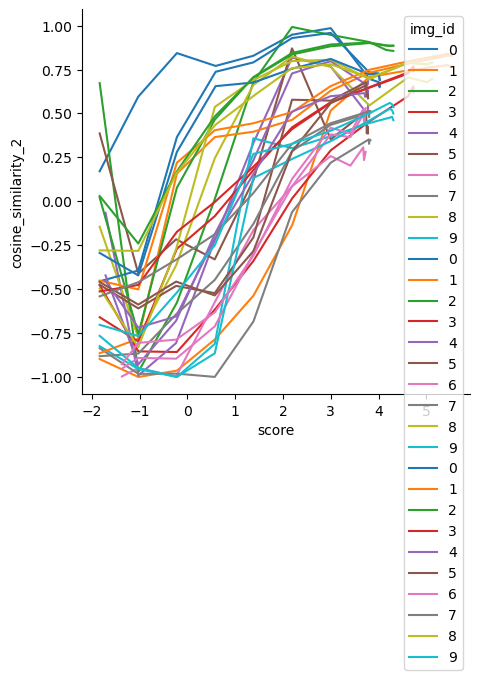

In [35]:
model_name = "resnet50_robust"
stats_dict = stats_dict_index[(model_name, unit_id)]
df = stats_dict["df"]
for pc_cutoff in pc_cutoffs:
    df[f"cosine_similarity_{pc_cutoff}"] = cosine_results[(model_name, unit_id, pc_cutoff)]
acc_unit_df = df.query("model_name == @model_name and unit_id == @unit_id")
plt.figure(figsize=(5, 5))
for pc_cutoff in [2,3,5]:
    sns.lineplot(x="score", y=f"cosine_similarity_{pc_cutoff}", data=acc_unit_df, 
                hue="img_id", palette="tab10",
                markers=True, legend=True) # label=f"PC {pc_cutoff}", 
plt.show()

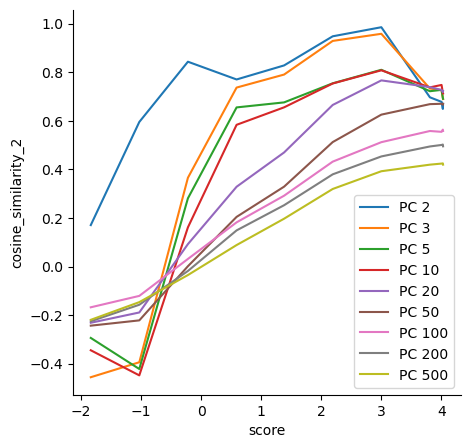

In [ ]:
acc_unit_df = df.query("model_name == @model_name and unit_id == @unit_id and img_id == 0")
plt.figure(figsize=(5, 5))
for pc_cutoff in [2,3,5, 10, 20, 50, 100, 200, 500]:
    sns.lineplot(data=acc_unit_df, x="score", y=f"cosine_similarity_{pc_cutoff}",  # hue="img_id", palette="tab10", 
                label=f"PC {pc_cutoff}", 
                markers=True, legend=True) # label=f"PC {pc_cutoff}", 
plt.show()

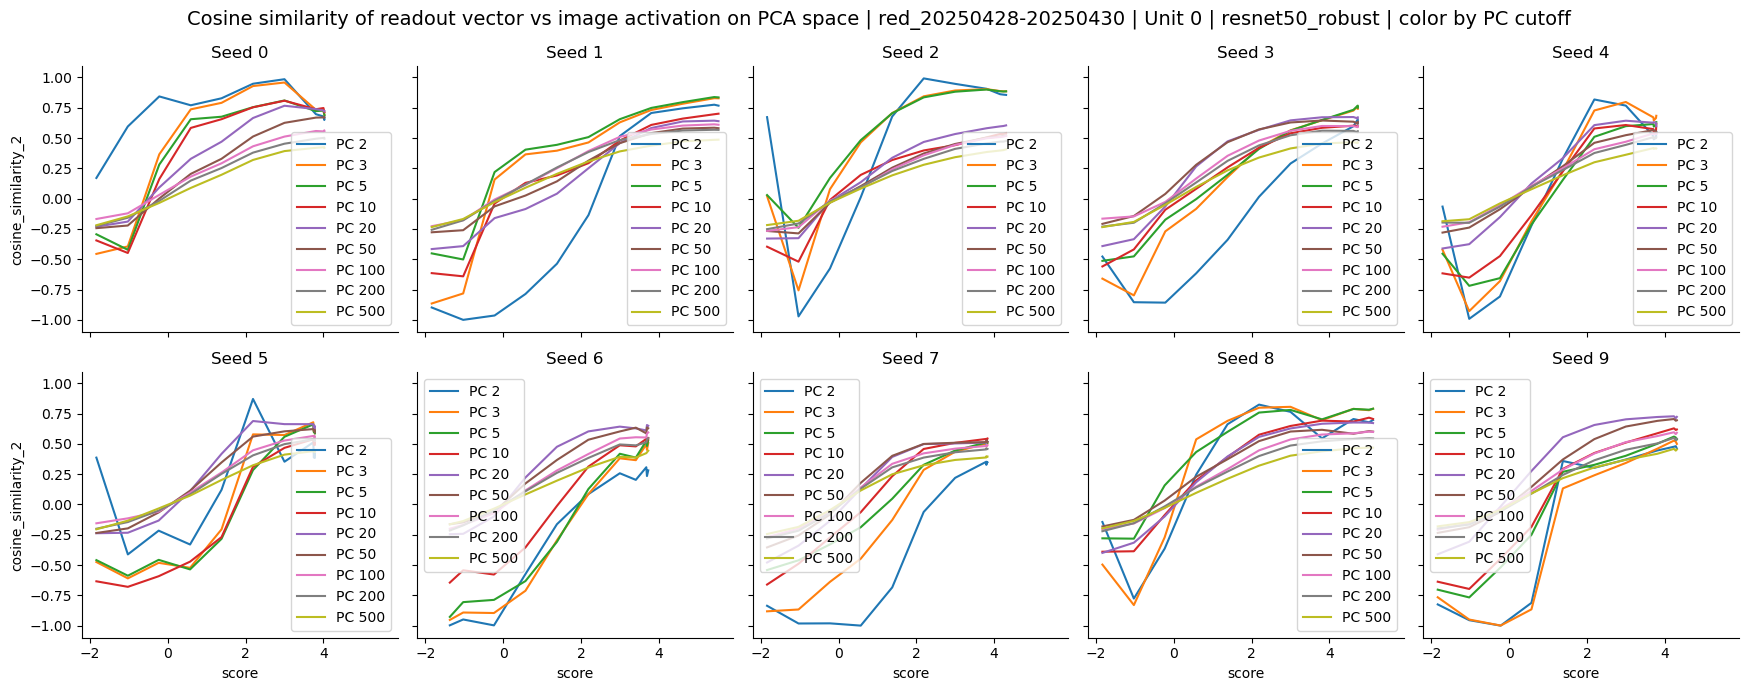

In [43]:
# Get unique img_ids for creating subplots
img_ids = df.query("model_name == @model_name and unit_id == @unit_id")["img_id"].unique()
n_imgs = len(img_ids)
nrows = 2
ncols = n_imgs // nrows
fig, axes = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.5*nrows), sharey=True, sharex=True)
axes = axes.flatten()
for i, img_id in enumerate(img_ids):
    acc_unit_df = df.query("model_name == @model_name and unit_id == @unit_id and img_id == @img_id")
    for pc_cutoff in [2, 3, 5, 10, 20, 50, 100, 200, 500]:
        sns.lineplot(data=acc_unit_df, x="score", y=f"cosine_similarity_{pc_cutoff}",  # hue="img_id", palette="tab10", 
                    label=f"PC {pc_cutoff}", markers=True, legend=True, ax=axes[i]) # label=f"PC {pc_cutoff}", 
    axes[i].set_title(f"Seed {img_id}")
plt.suptitle(f"Cosine similarity of readout vector vs image activation on PCA space | {subject_id} | Unit {unit_id} | {model_name} | color by PC cutoff", fontsize=14)
plt.tight_layout()
plt.show()

In [44]:
unit_id

0

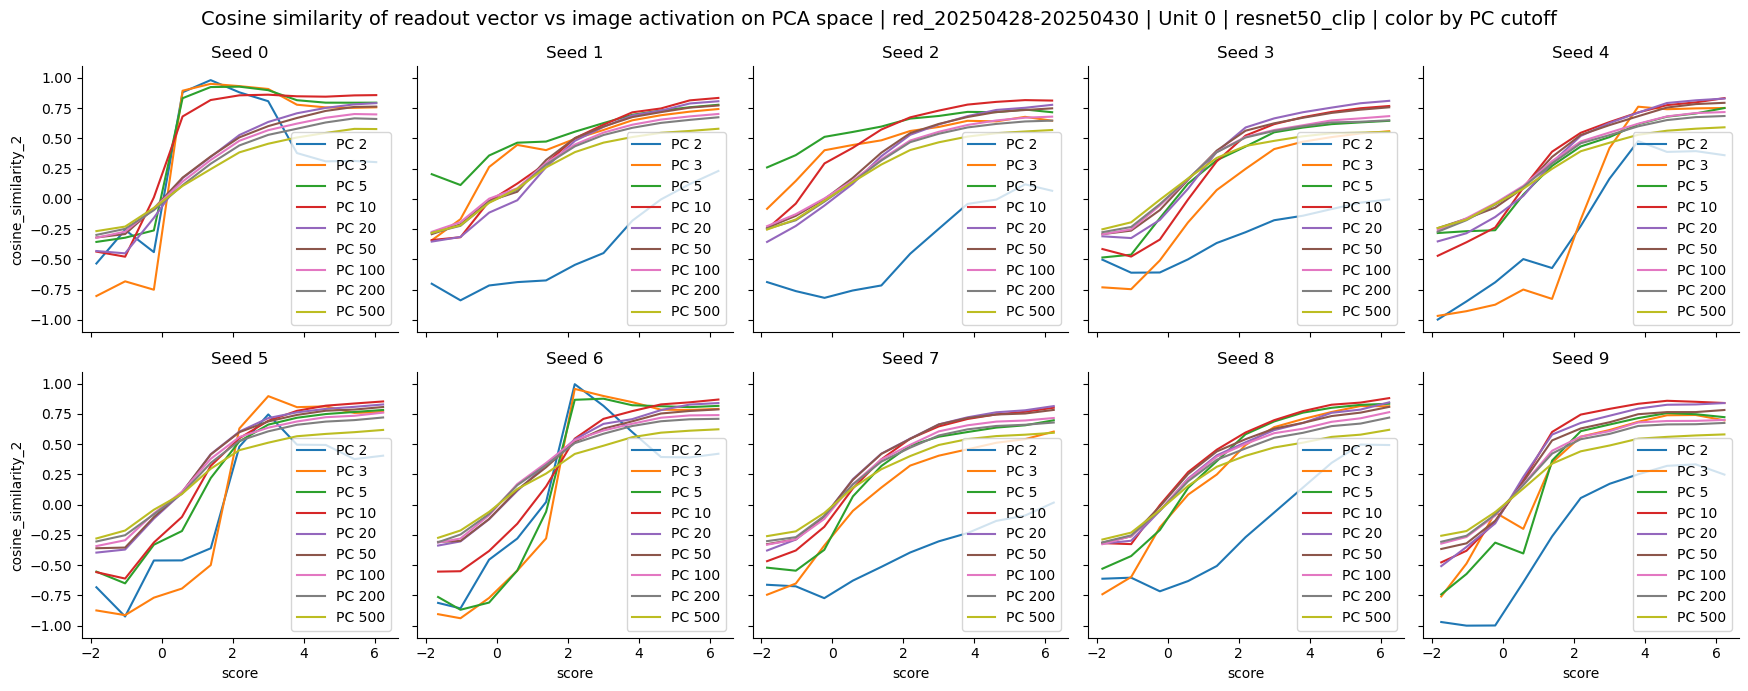

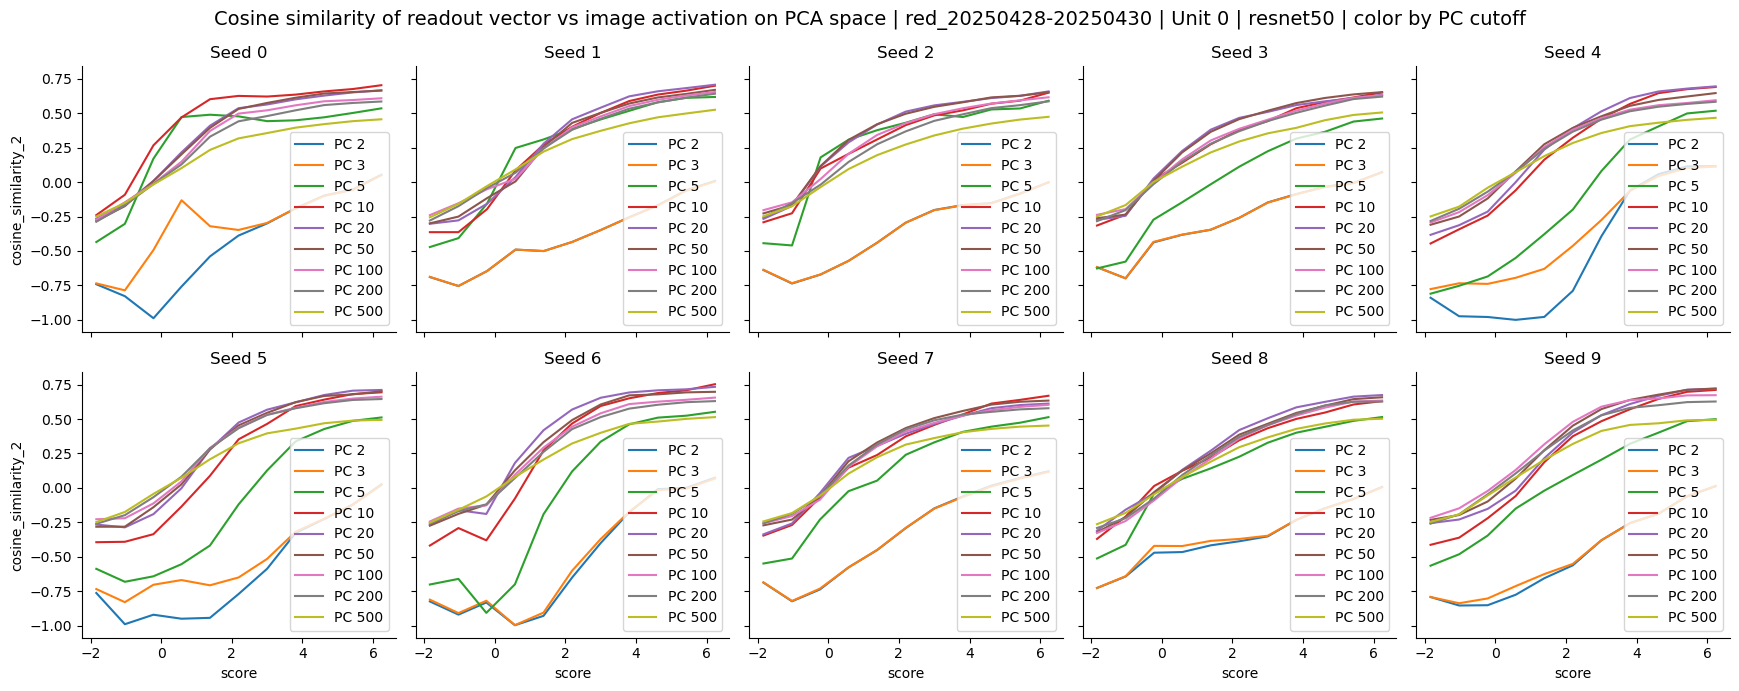

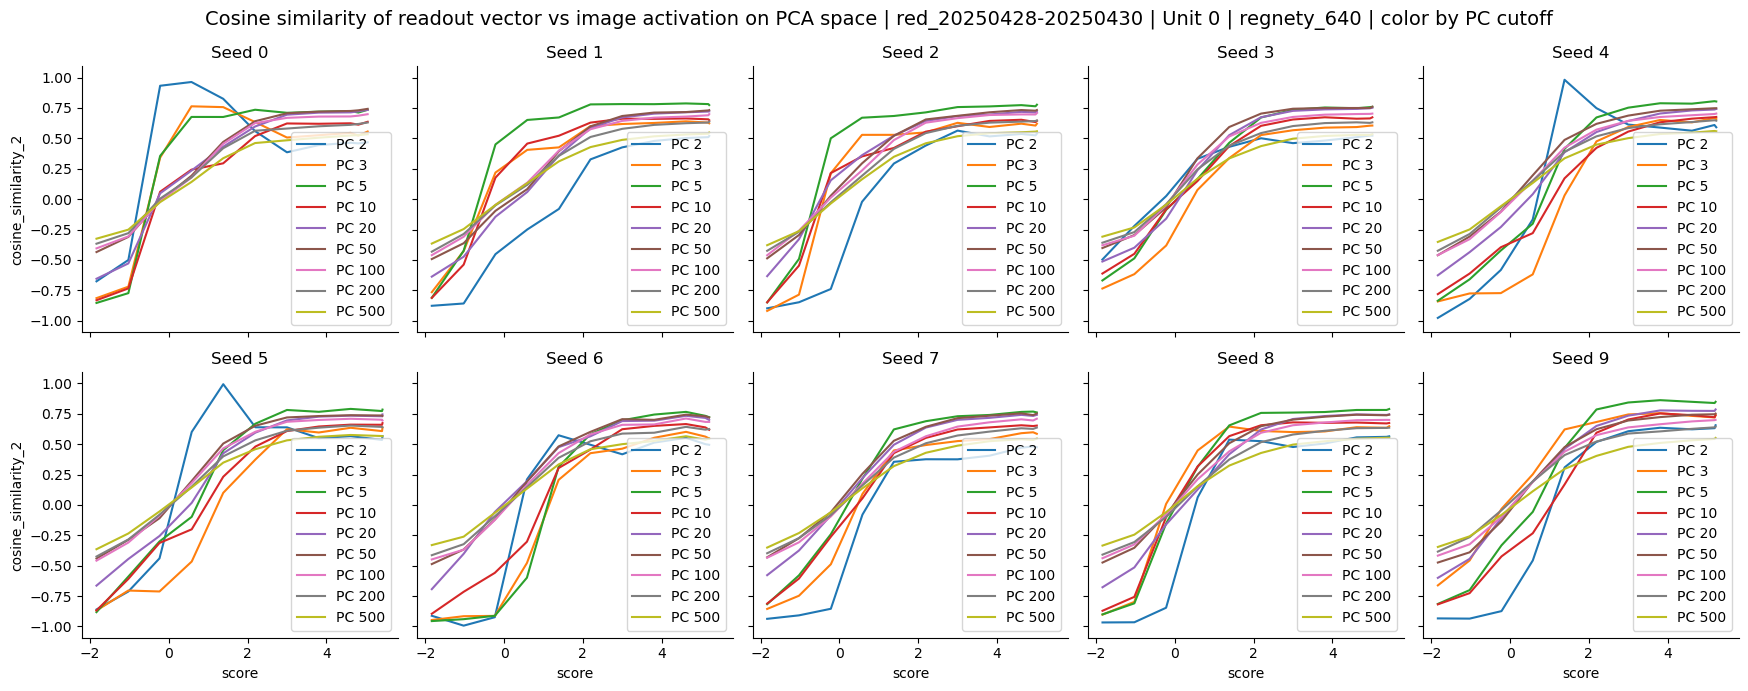

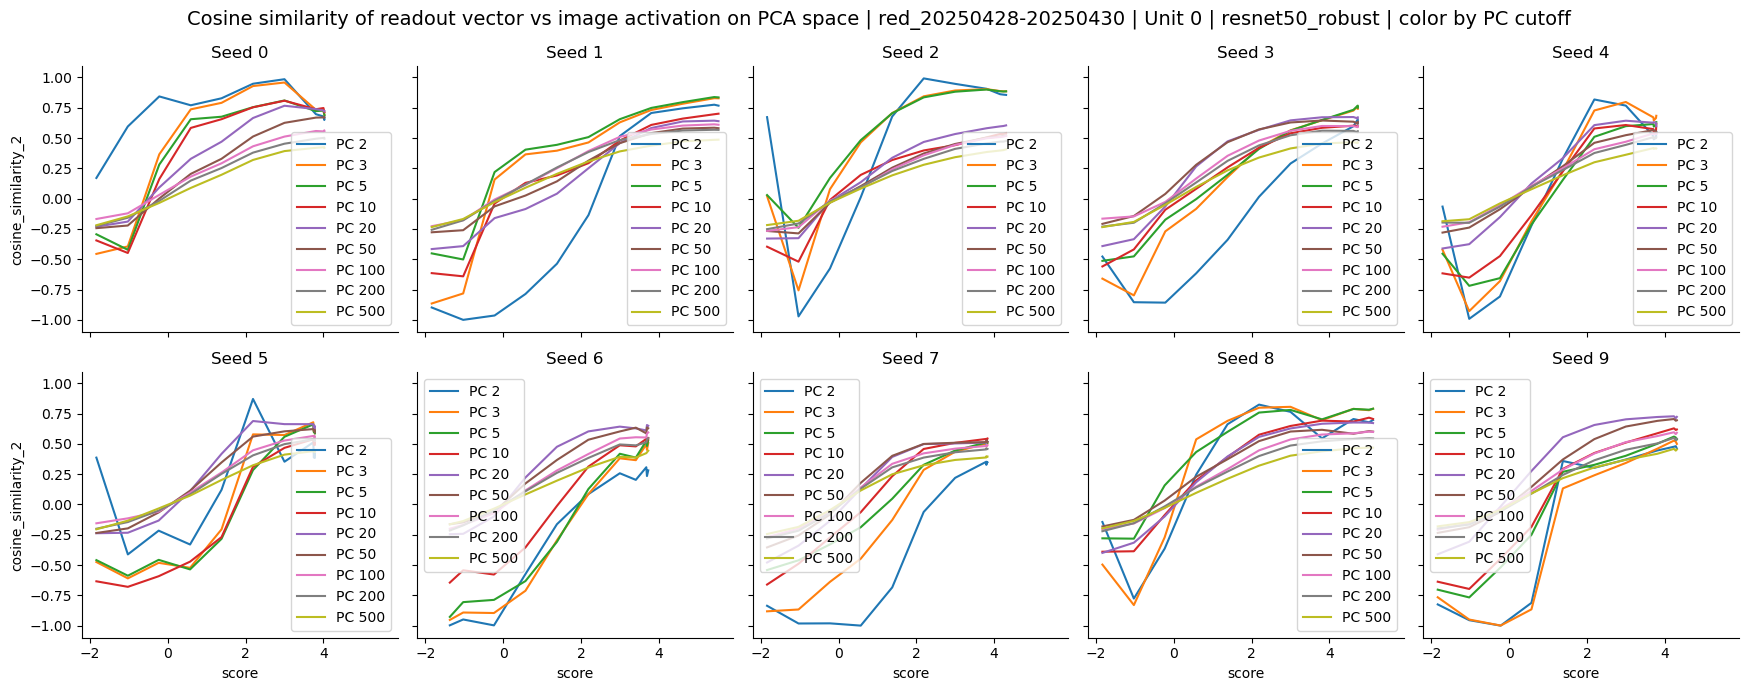

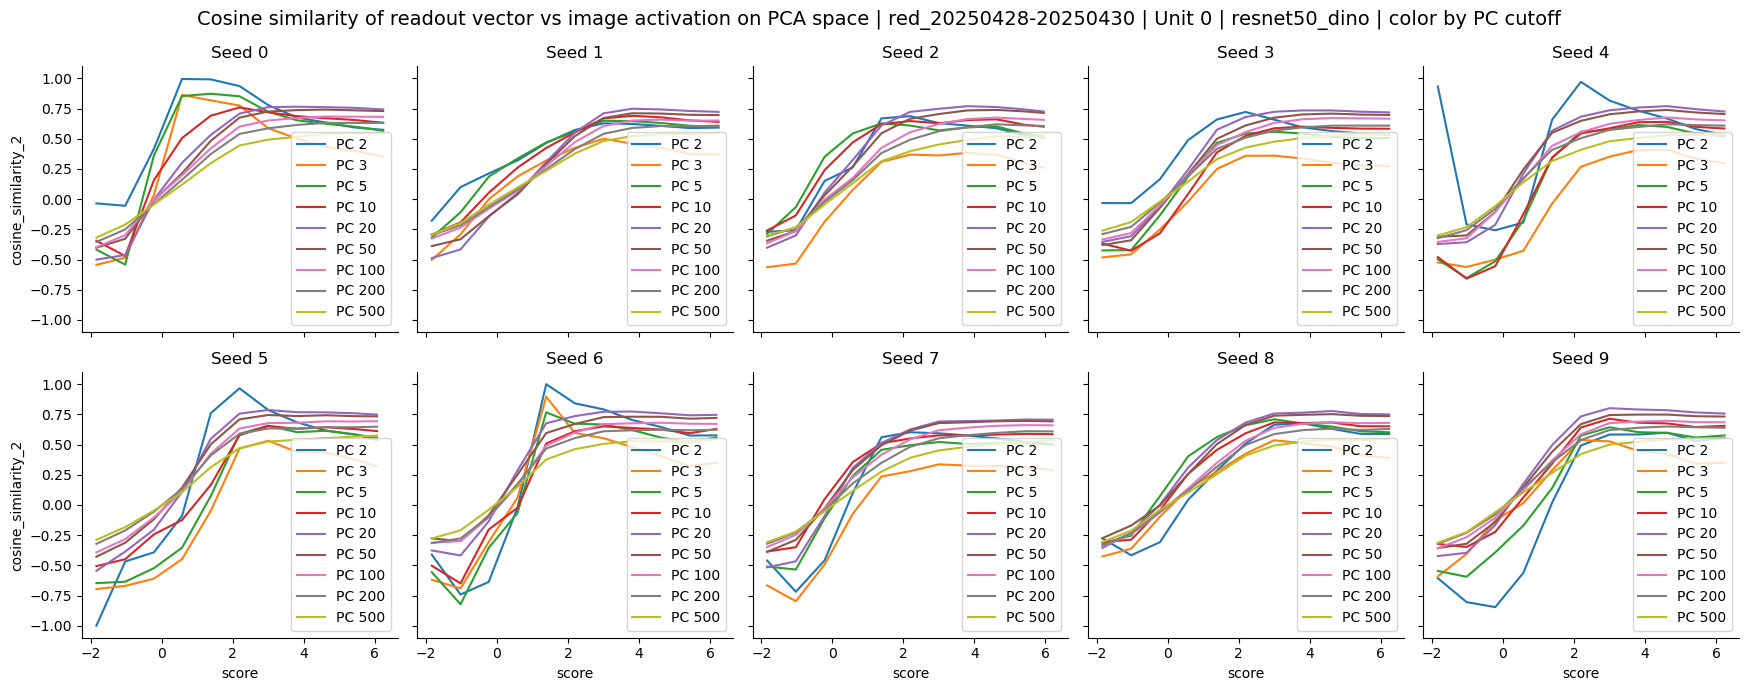

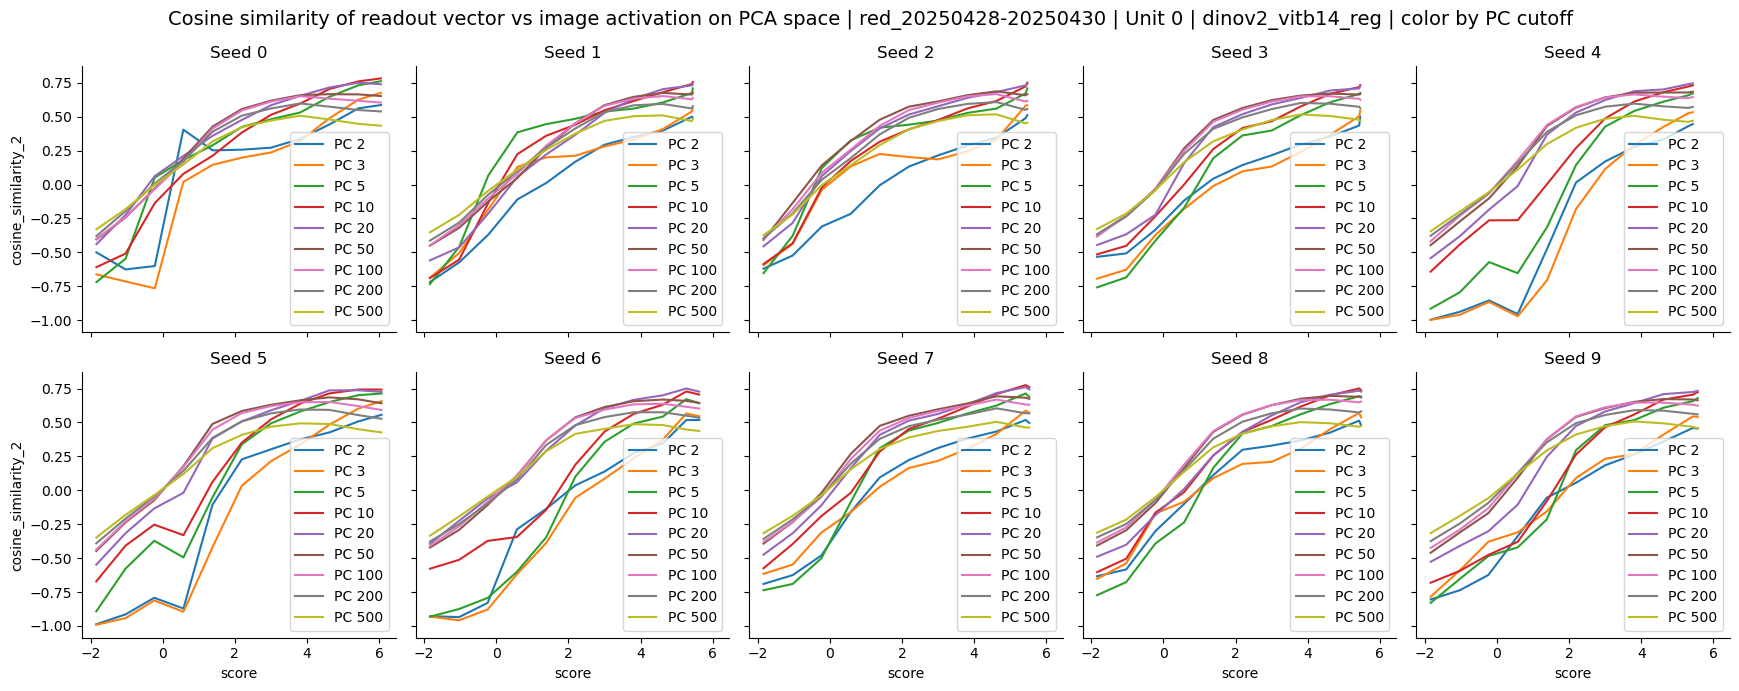

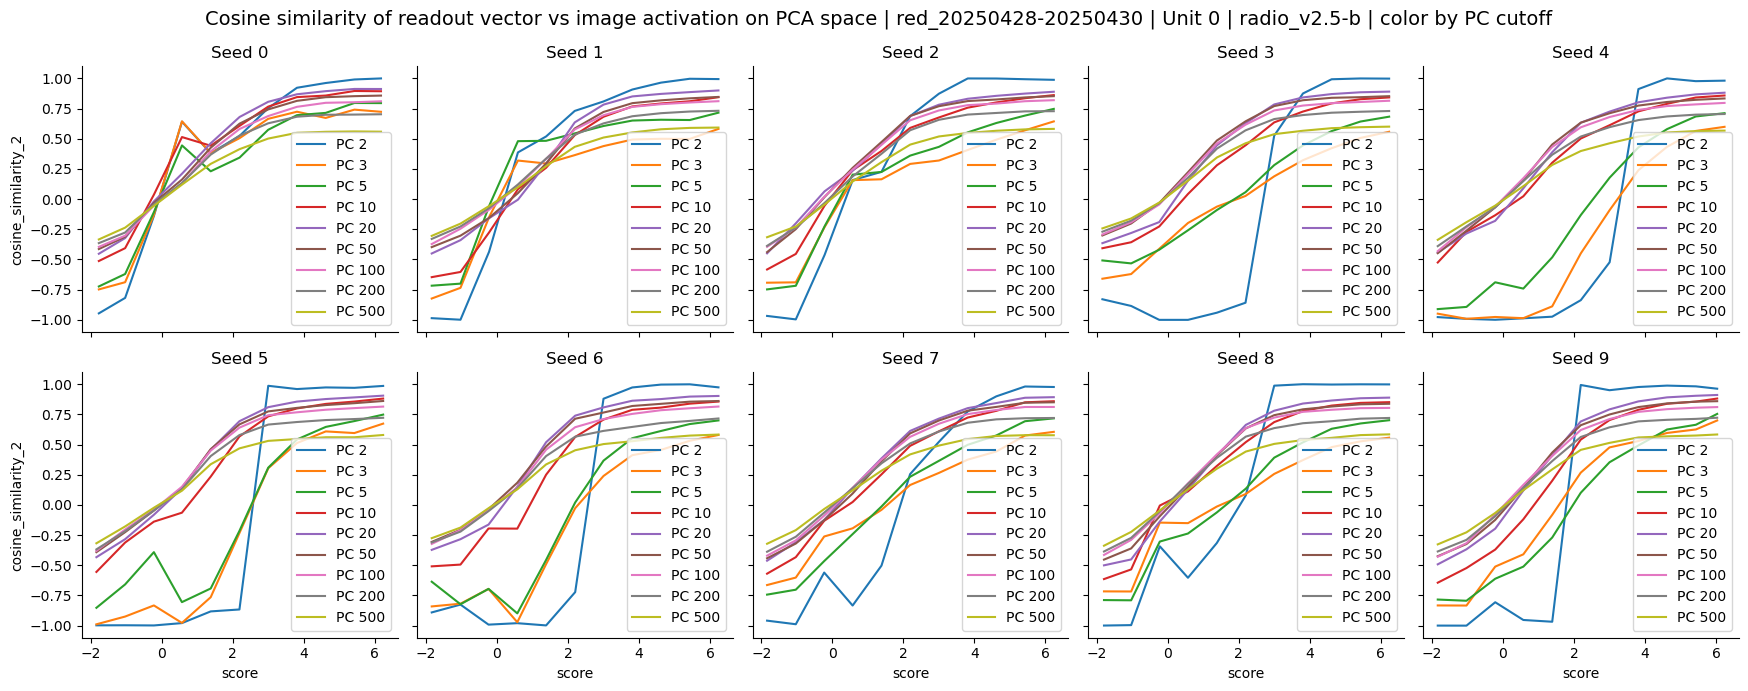

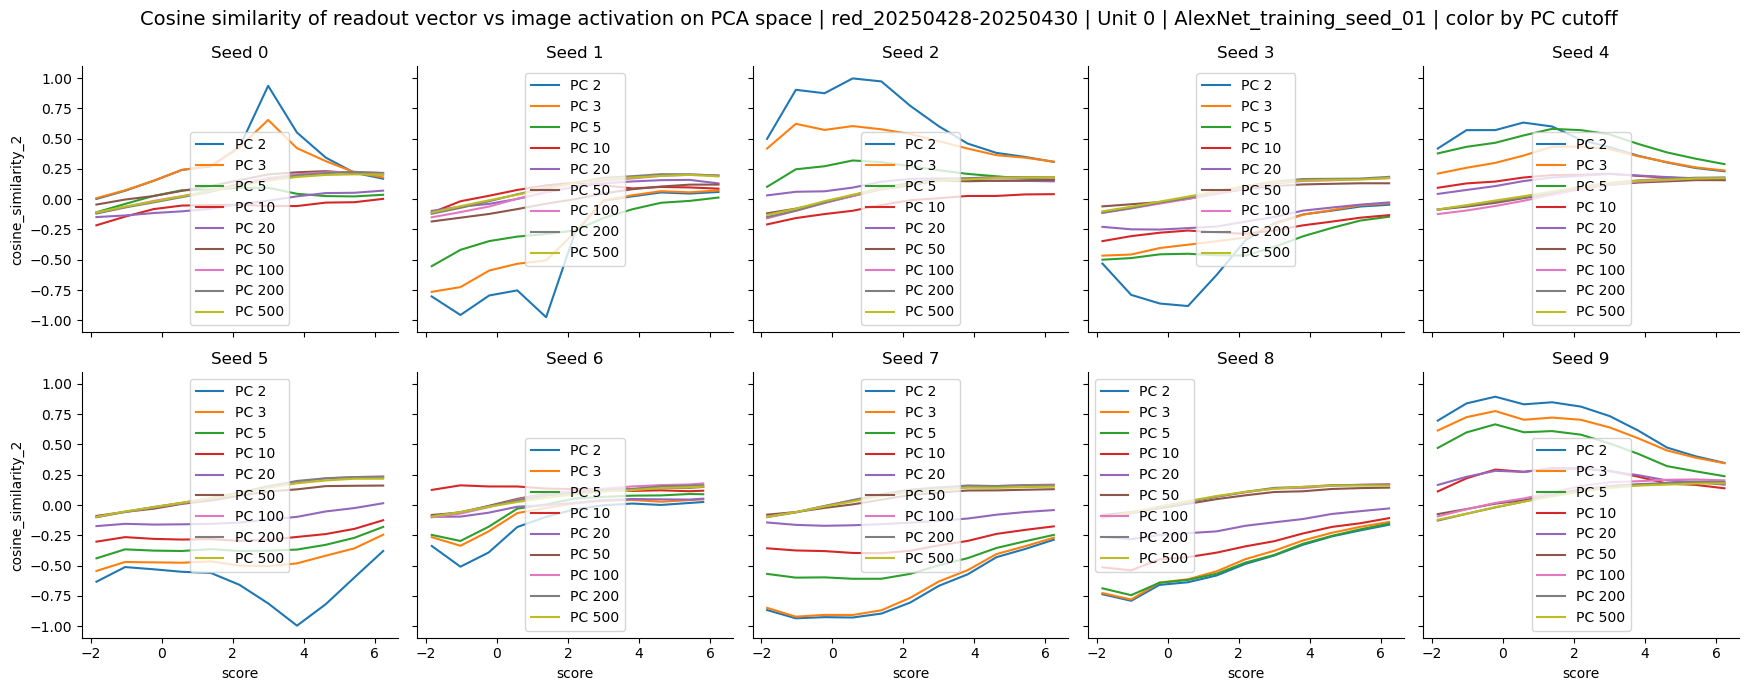

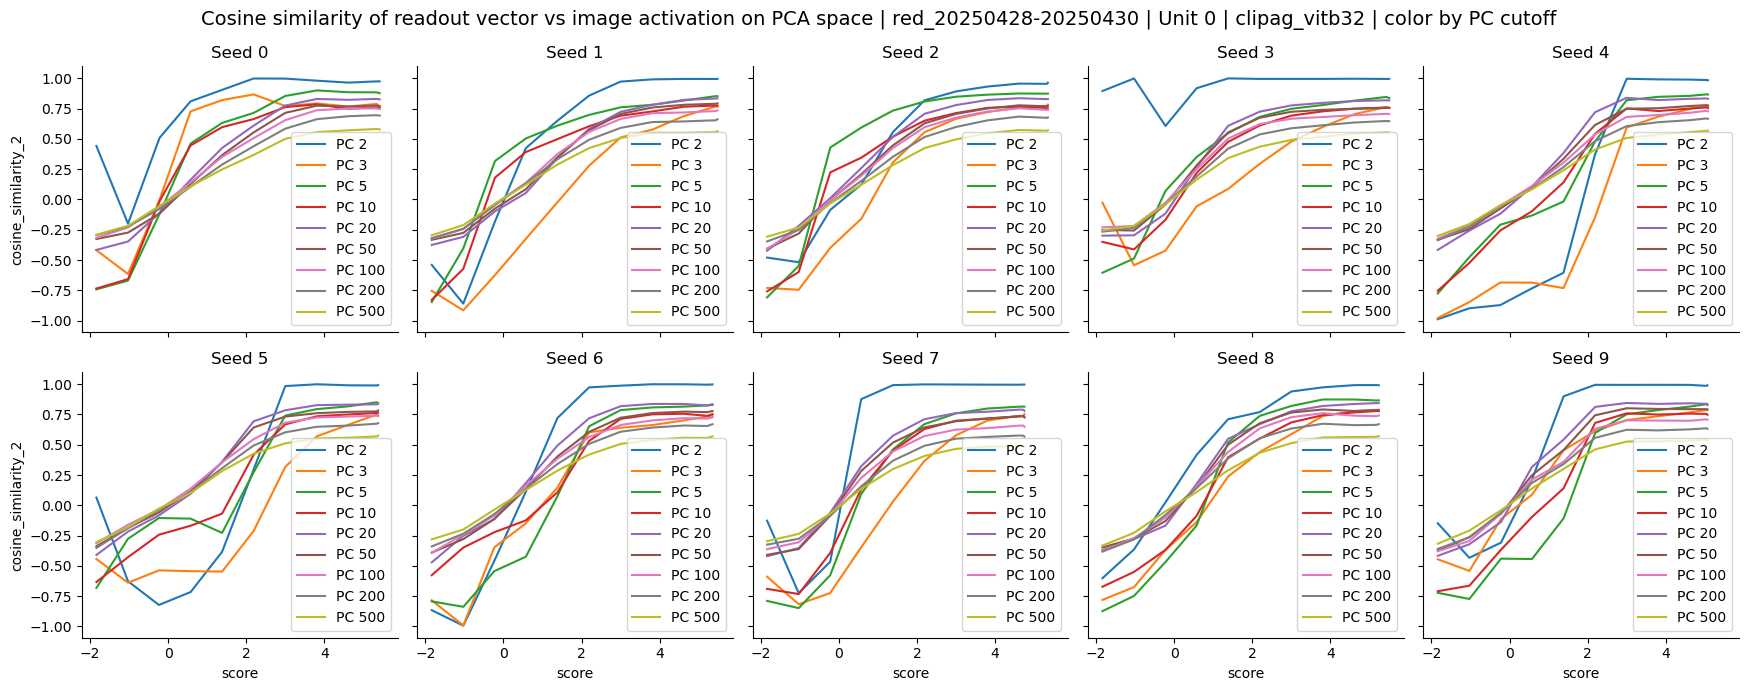

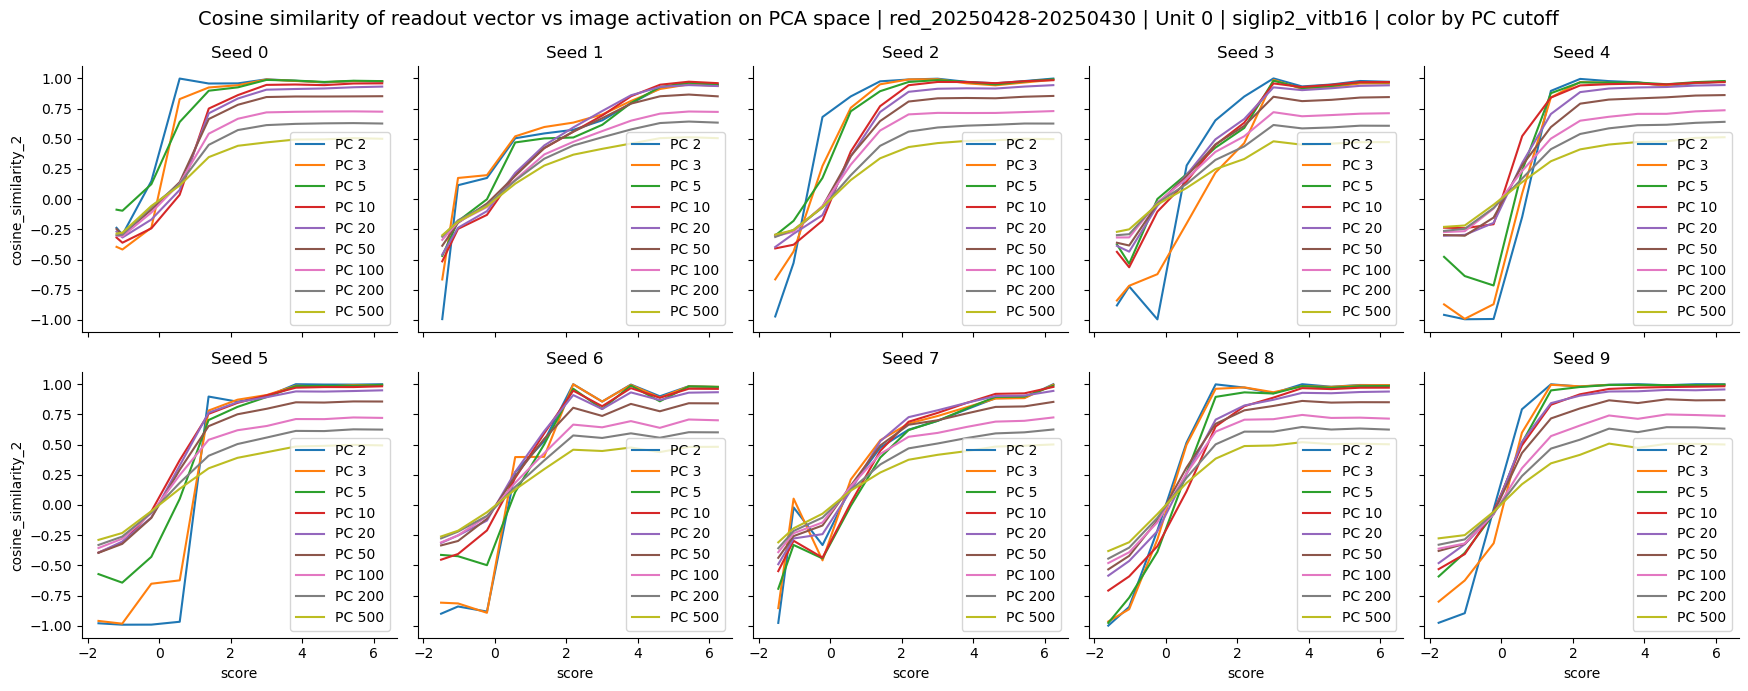

In [45]:
unit_id = 0
for model_name in model_names:
    stats_dict = stats_dict_index[(model_name, unit_id)]
    df = stats_dict["df"]
    for pc_cutoff in pc_cutoffs:
        df[f"cosine_similarity_{pc_cutoff}"] = cosine_results[(model_name, unit_id, pc_cutoff)]
    # Get unique img_ids for creating subplots
    img_ids = df.query("model_name == @model_name and unit_id == @unit_id")["img_id"].unique()
    n_imgs = len(img_ids)
    nrows = 2
    ncols = n_imgs // nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.5*nrows), sharey=True, sharex=True)
    axes = axes.flatten()
    for i, img_id in enumerate(img_ids):
        acc_unit_df = df.query("model_name == @model_name and unit_id == @unit_id and img_id == @img_id")
        for pc_cutoff in [2, 3, 5, 10, 20, 50, 100, 200, 500]:
            sns.lineplot(data=acc_unit_df, x="score", y=f"cosine_similarity_{pc_cutoff}",  # hue="img_id", palette="tab10", 
                        label=f"PC {pc_cutoff}", markers=True, legend=True, ax=axes[i]) # label=f"PC {pc_cutoff}", 
        axes[i].set_title(f"Seed {img_id}")
    plt.suptitle(f"Cosine similarity of readout vector vs image activation on PCA space | {subject_id} | Unit {unit_id} | {model_name} | color by PC cutoff", fontsize=14)
    plt.tight_layout()
    plt.show()

In [46]:
# develop a metric to evaluate the alignment of the readout vector to the PCA space
acc_unit_df = df.query("model_name == @model_name and unit_id == @unit_id and img_id == @img_id")

In [47]:
acc_unit_df

model_name  unit_id  img_id     level     score  \
5049  siglip2_vitb16        0       9 -0.228237 -0.218491   
5050  siglip2_vitb16        0       9 -1.037346 -1.027798   
5051  siglip2_vitb16        0       9 -1.846455 -1.757764   
5052  siglip2_vitb16        0       9  0.580873  0.571428   
5053  siglip2_vitb16        0       9  1.389982  1.384050   
5054  siglip2_vitb16        0       9  2.199091  2.193117   
5055  siglip2_vitb16        0       9  3.008200  3.008548   
5056  siglip2_vitb16        0       9  3.817309  3.813667   
5057  siglip2_vitb16        0       9  4.626418  4.619596   
5058  siglip2_vitb16        0       9  5.435527  5.433906   
5059  siglip2_vitb16        0       9  6.244637  6.234783   

                                               filepath  cosine_similarity  \
5049  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...          -0.033716   
5050  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...          -0.200531   
5051  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...          -0.229200   
5052  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.143813   
5053  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.301557   
5054  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.338031   
5055  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.419583   
5056  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.374261   
5057  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.407906   
5058  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.409149   
5059  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.401747   

        PCA_norm  cosine_similarity_2  cosine_similarity_3  ...  \
5049  326.056366            -0.033298            -0.317223  ...   
5050  252.773819            -0.896317            -0.625507  ...   
5051  378.137909            -0.975867            -0.800451  ...   
5052  195.347198             0.792222             0.598382  ...   
5053  224.013870             0.999151             0.994997  ...   
5054  319.179169             0.980599             0.982392  ...   
5055  354.029968             0.995395             0.994135  ...   
5056  500.774536             0.999828             0.992350  ...   
5057  558.789551             0.991711             0.989656  ...   
5058  653.428955             0.999889             0.989617  ...   
5059  763.973816             0.999642             0.994880  ...   

      cosine_similarity_660  cosine_similarity_670  cosine_similarity_680  \
5049              -0.037212              -0.034682              -0.034836   
5050              -0.204114              -0.206202              -0.204855   
5051              -0.236005              -0.237628              -0.235588   
5052               0.150482               0.150918               0.146939   
5053               0.315141               0.314898               0.311517   
5054               0.357154               0.355928               0.352684   
5055               0.443384               0.439424               0.435714   
5056               0.395645               0.393448               0.390633   
5057               0.431240               0.428021               0.425064   
5058               0.428516               0.426559               0.423724   
5059               0.425270               0.423444               0.419644   

      cosine_similarity_690  cosine_similarity_700  cosine_similarity_710  \
5049              -0.033842              -0.035196              -0.034937   
5050              -0.203035              -0.204288              -0.203779   
5051              -0.234992              -0.235446              -0.234465   
5052               0.144922               0.144037               0.142470   
5053               0.308927               0.308179               0.304208   
5054               0.349016               0.348449               0.345145   
5055               0.433620               0.432260               0.4288

In [53]:
def compute_alignment_metrics(acc_unit_df):
    alignment_metrics = []
    for pc_cutoff in pc_cutoffs:
        avg_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].abs().mean()
        peak_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].abs().max()
        peak_pos_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].max()
        peak_neg_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].min()
        
        alignment_metrics.append({
            'pc_cutoff': pc_cutoff,
            'avg_alignment': avg_alignment,
            'peak_alignment': peak_alignment,
            'peak_pos_alignment': peak_pos_alignment,
            'peak_neg_alignment': peak_neg_alignment
        })

    alignment_df = pd.DataFrame(alignment_metrics)#.set_index('pc_cutoff')
    return alignment_df

In [58]:
acc_unit_df

model_name  unit_id  img_id     level     score  \
5049  siglip2_vitb16        0       9 -0.228237 -0.218491   
5050  siglip2_vitb16        0       9 -1.037346 -1.027798   
5051  siglip2_vitb16        0       9 -1.846455 -1.757764   
5052  siglip2_vitb16        0       9  0.580873  0.571428   
5053  siglip2_vitb16        0       9  1.389982  1.384050   
5054  siglip2_vitb16        0       9  2.199091  2.193117   
5055  siglip2_vitb16        0       9  3.008200  3.008548   
5056  siglip2_vitb16        0       9  3.817309  3.813667   
5057  siglip2_vitb16        0       9  4.626418  4.619596   
5058  siglip2_vitb16        0       9  5.435527  5.433906   
5059  siglip2_vitb16        0       9  6.244637  6.234783   

                                               filepath  cosine_similarity  \
5049  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...          -0.033716   
5050  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...          -0.200531   
5051  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...          -0.229200   
5052  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.143813   
5053  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.301557   
5054  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.338031   
5055  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.419583   
5056  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.374261   
5057  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.407906   
5058  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.409149   
5059  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...           0.401747   

        PCA_norm  cosine_similarity_2  cosine_similarity_3  ...  \
5049  326.056366            -0.033298            -0.317223  ...   
5050  252.773819            -0.896317            -0.625507  ...   
5051  378.137909            -0.975867            -0.800451  ...   
5052  195.347198             0.792222             0.598382  ...   
5053  224.013870             0.999151             0.994997  ...   
5054  319.179169             0.980599             0.982392  ...   
5055  354.029968             0.995395             0.994135  ...   
5056  500.774536             0.999828             0.992350  ...   
5057  558.789551             0.991711             0.989656  ...   
5058  653.428955             0.999889             0.989617  ...   
5059  763.973816             0.999642             0.994880  ...   

      cosine_similarity_660  cosine_similarity_670  cosine_similarity_680  \
5049              -0.037212              -0.034682              -0.034836   
5050              -0.204114              -0.206202              -0.204855   
5051              -0.236005              -0.237628              -0.235588   
5052               0.150482               0.150918               0.146939   
5053               0.315141               0.314898               0.311517   
5054               0.357154               0.355928               0.352684   
5055               0.443384               0.439424               0.435714   
5056               0.395645               0.393448               0.390633   
5057               0.431240               0.428021               0.425064   
5058               0.428516               0.426559               0.423724   
5059               0.425270               0.423444               0.419644   

      cosine_similarity_690  cosine_similarity_700  cosine_similarity_710  \
5049              -0.033842              -0.035196              -0.034937   
5050              -0.203035              -0.204288              -0.203779   
5051              -0.234992              -0.235446              -0.234465   
5052               0.144922               0.144037               0.142470   
5053               0.308927               0.308179               0.304208   
5054               0.349016               0.348449               0.345145   
5055               0.433620               0.432260               0.4288

In [ ]:
alignment_metrics = []
for pc_cutoff in pc_cutoffs:
    avg_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].abs().mean()
    peak_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].abs().max()
    peak_pos_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].max()
    peak_neg_alignment = acc_unit_df[f"cosine_similarity_{pc_cutoff}"].min()
    
    alignment_metrics.append({
        'pc_cutoff': pc_cutoff,
        'avg_alignment': avg_alignment,
        'peak_alignment': peak_alignment,
        'peak_pos_alignment': peak_pos_alignment,
        'peak_neg_alignment': peak_neg_alignment
    })

alignment_df = pd.DataFrame(alignment_metrics)#.set_index('pc_cutoff')

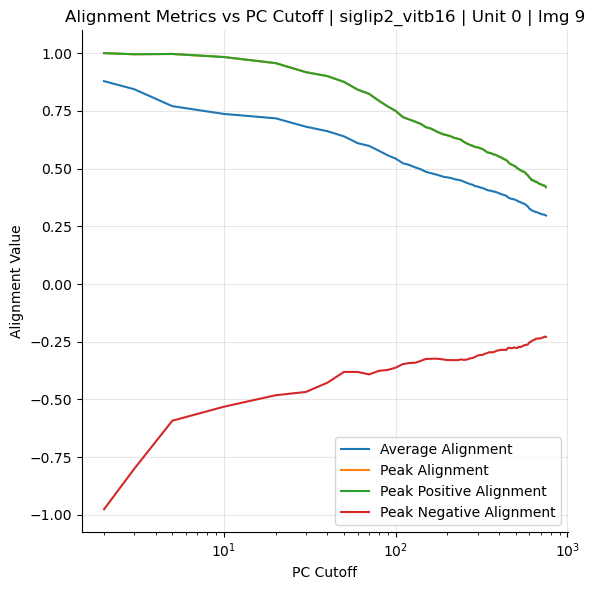

pc_cutoff  avg_alignment  peak_alignment  peak_pos_alignment  \
0           2       0.878538        0.999889            0.999889   
1           3       0.843599        0.994997            0.994997   
2           5       0.770196        0.996324            0.996324   
3          10       0.736552        0.982973            0.982973   
4          20       0.717574        0.956567            0.956567   
..        ...            ...             ...                 ...   
73        710       0.301904        0.428867            0.428867   
74        720       0.301192        0.427897            0.427897   
75        730       0.300472        0.426768            0.426768   
76        740       0.299183        0.424908            0.424908   
77        750       0.296318        0.419583            0.419583   

    peak_neg_alignment  
0            -0.975867  
1            -0.800451  
2            -0.592168  
3            -0.531507  
4            -0.481690  
..                 ...  
73           -0.234465  
74           -0.231028  
75           -0.230288  
76           -0.227435  
77           -0.229200  

[78 rows x 5 columns]

In [52]:
# Plot alignment metrics as function of PC cutoff
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
metrics = ['avg_alignment', 'peak_alignment', 'peak_pos_alignment', 'peak_neg_alignment']
titles = ['Average Alignment', 'Peak Alignment', 'Peak Positive Alignment', 'Peak Negative Alignment']
for metric, title in zip(metrics, titles):
    ax.plot(alignment_df['pc_cutoff'], alignment_df[metric], linewidth=1.5, label=title) # marker='o', , markersize=6
ax.set_xlabel('PC Cutoff')
ax.set_ylabel('Alignment Value')
ax.set_title(f'Alignment Metrics vs PC Cutoff | {model_name} | Unit {unit_id} | Img {img_id}')
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.legend()
plt.tight_layout()
plt.show()
alignment_df

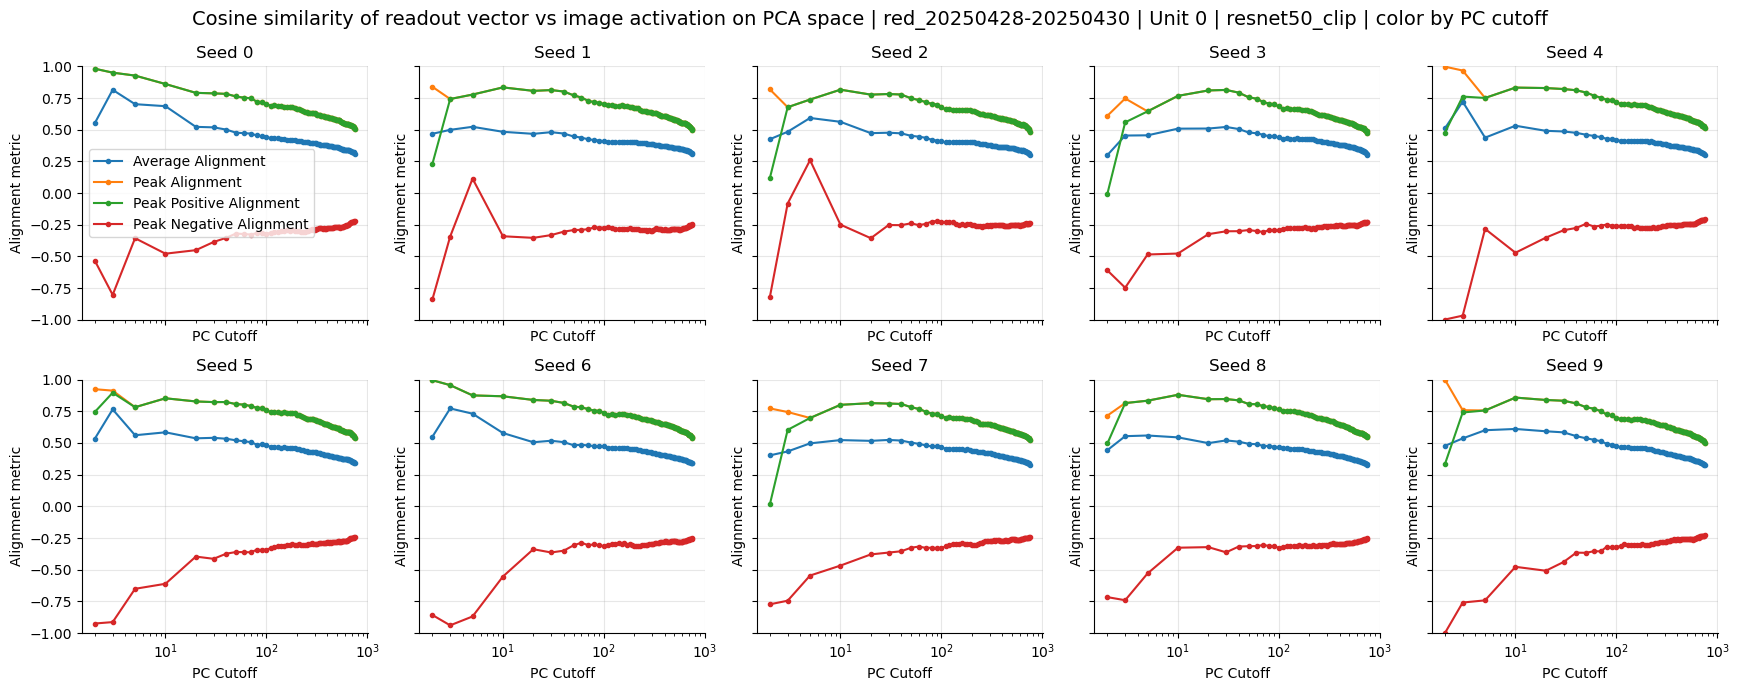

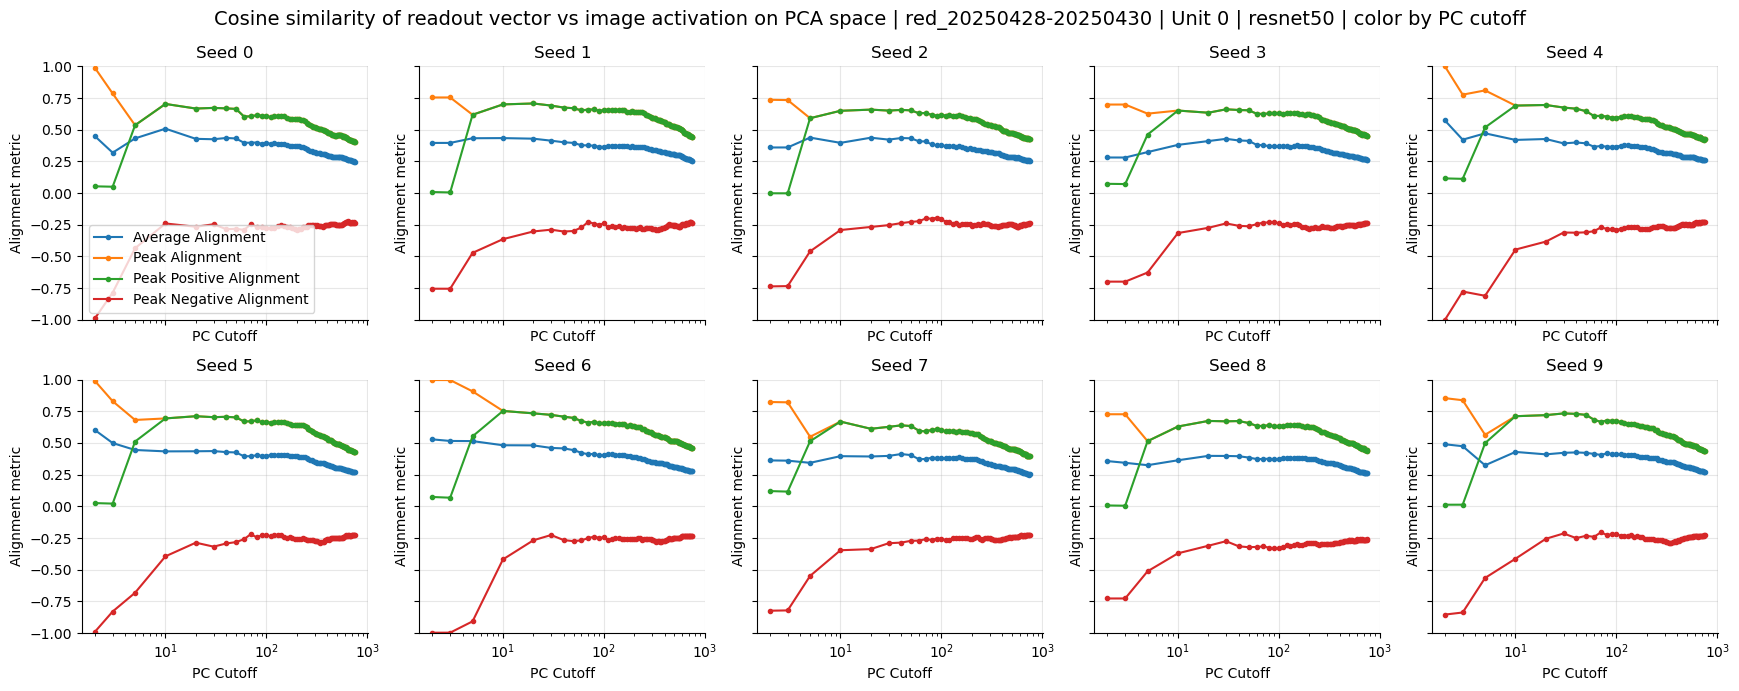

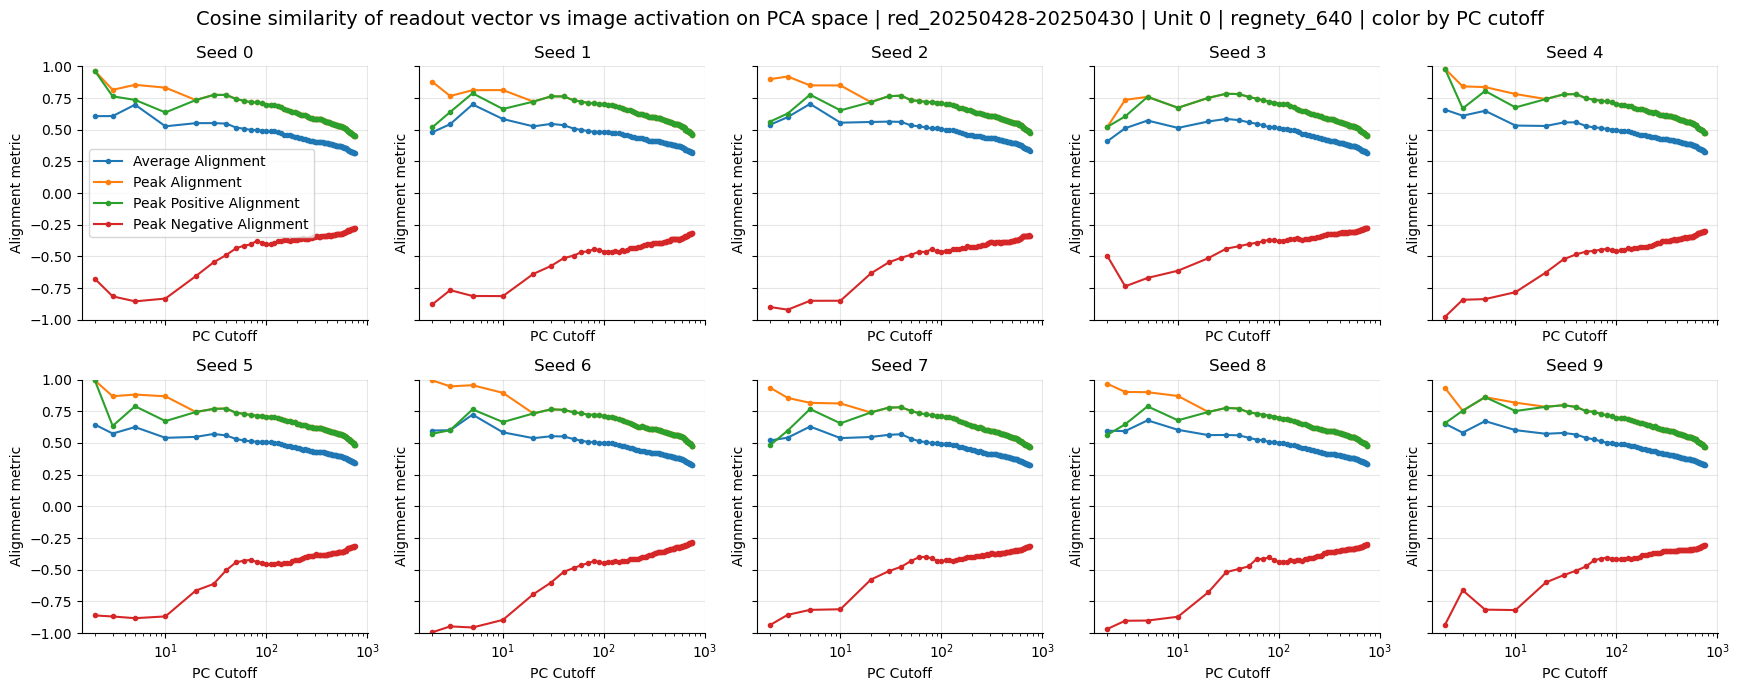

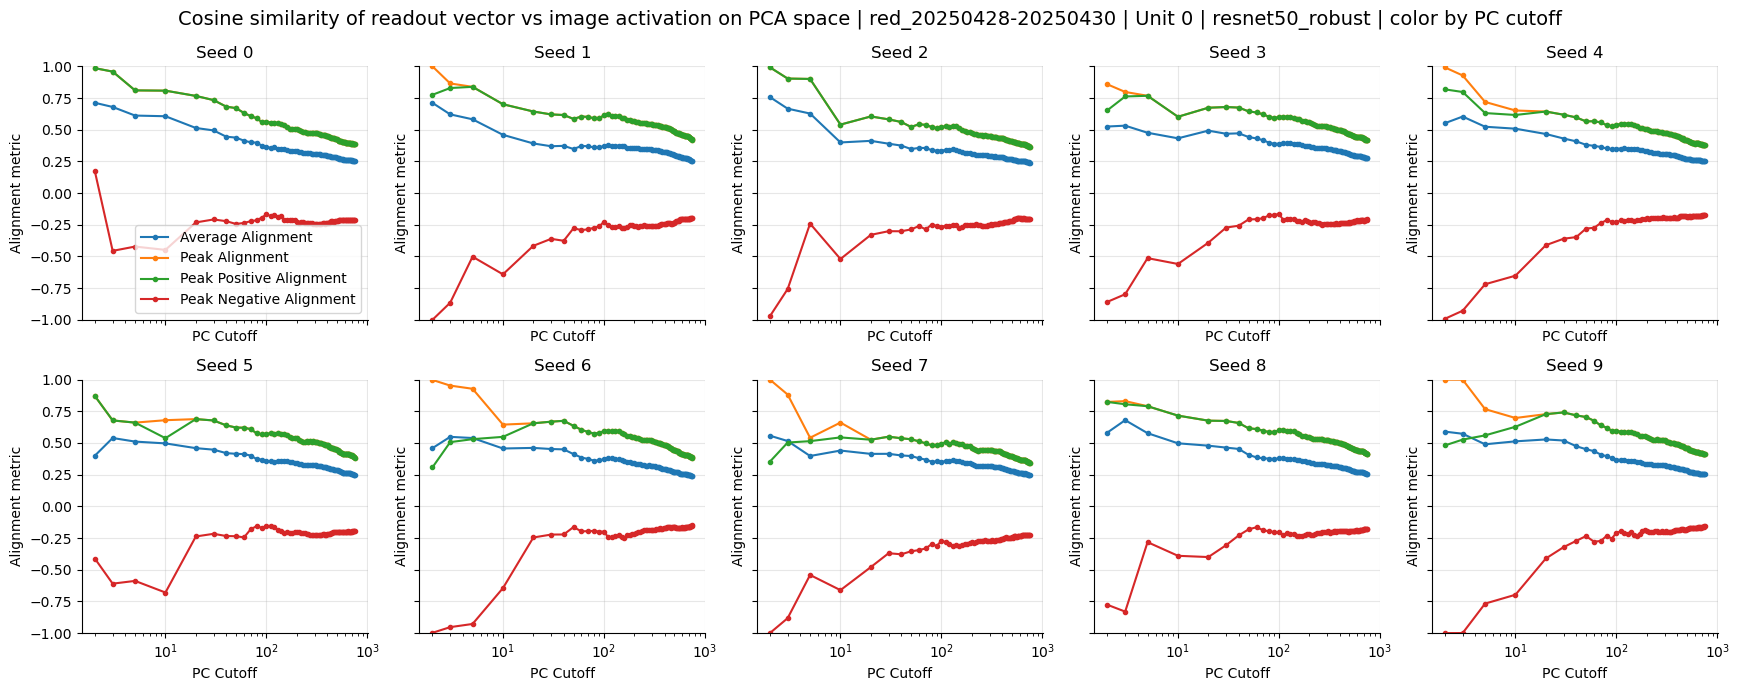

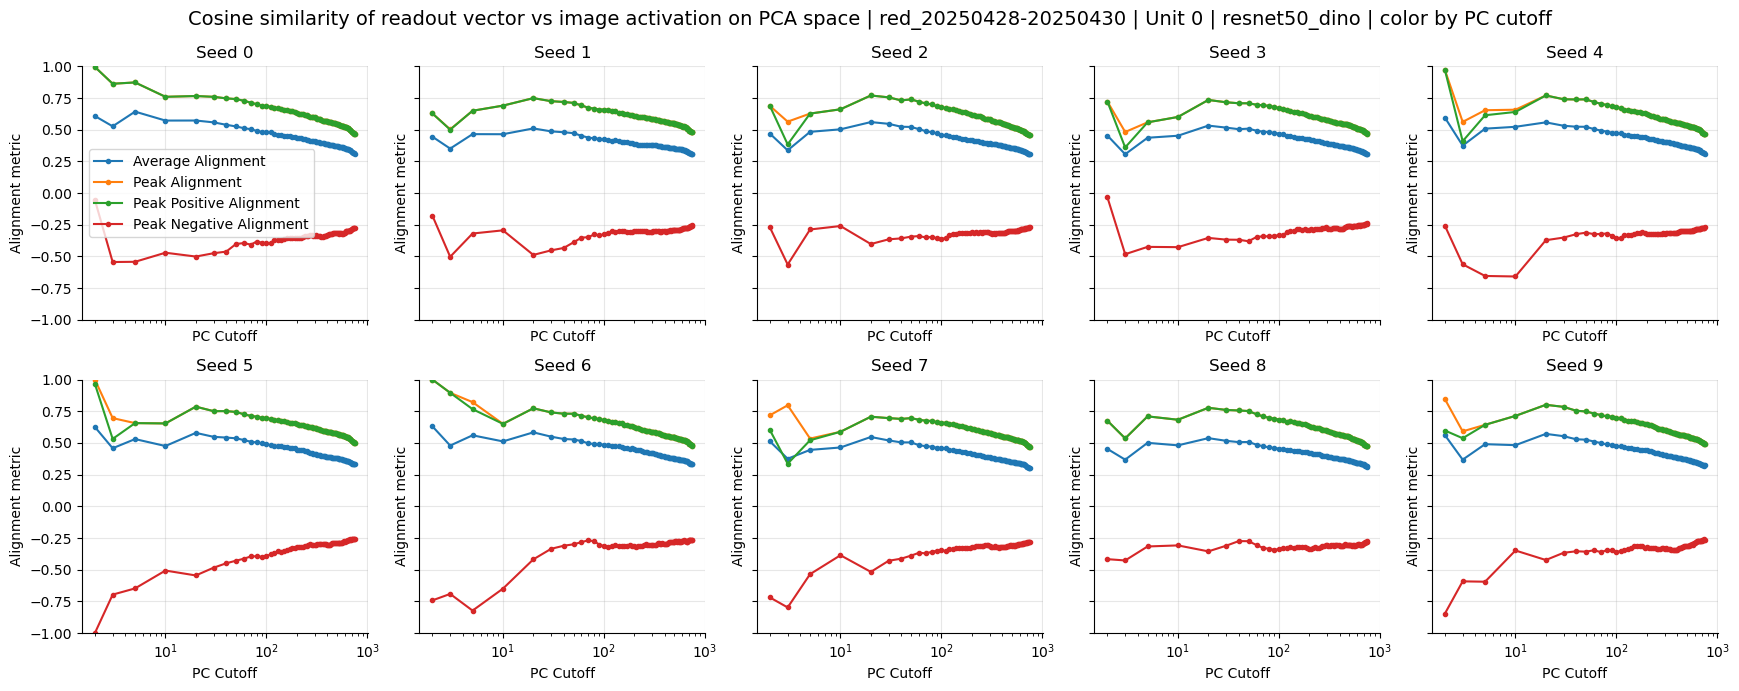

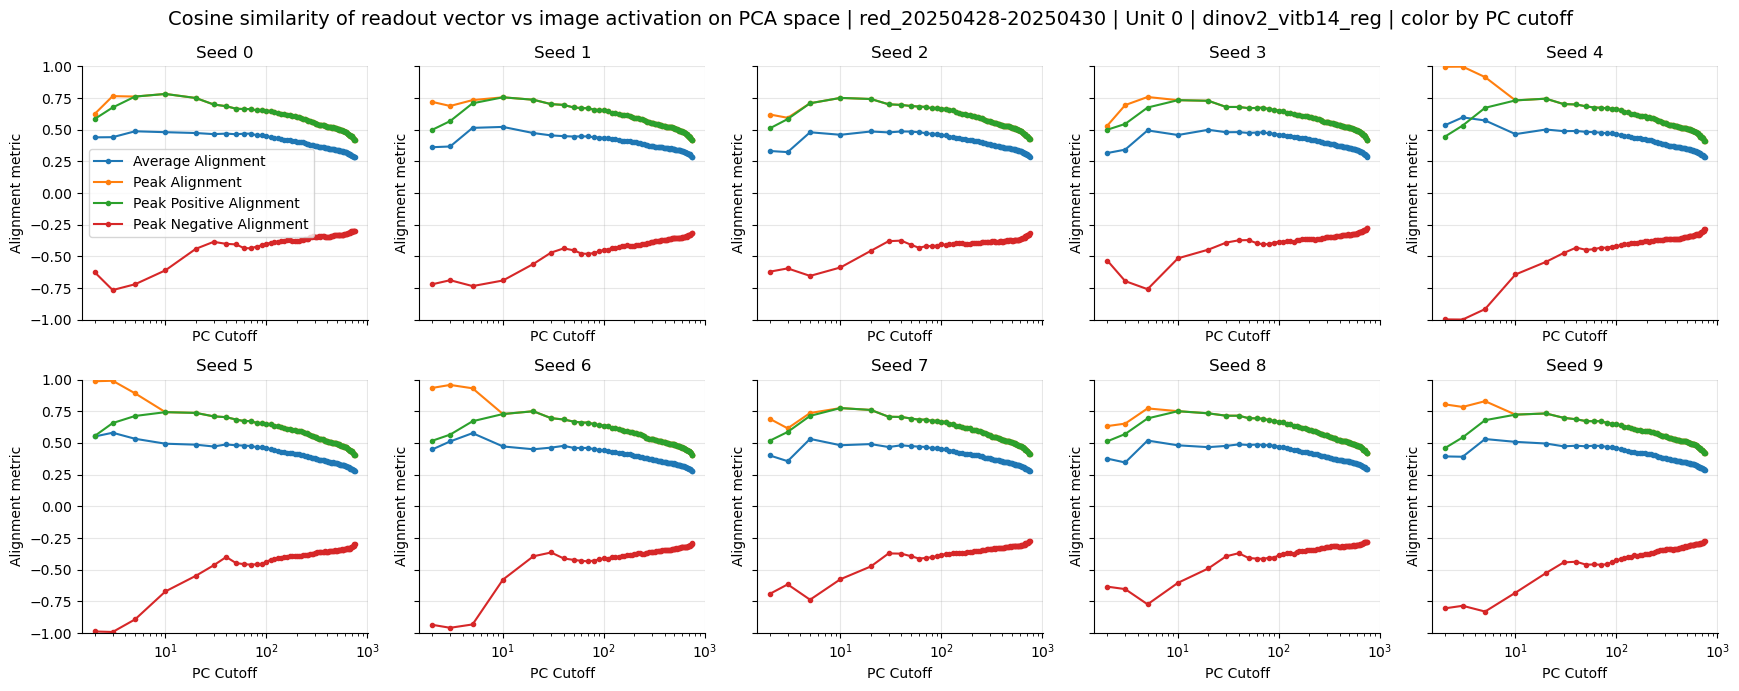

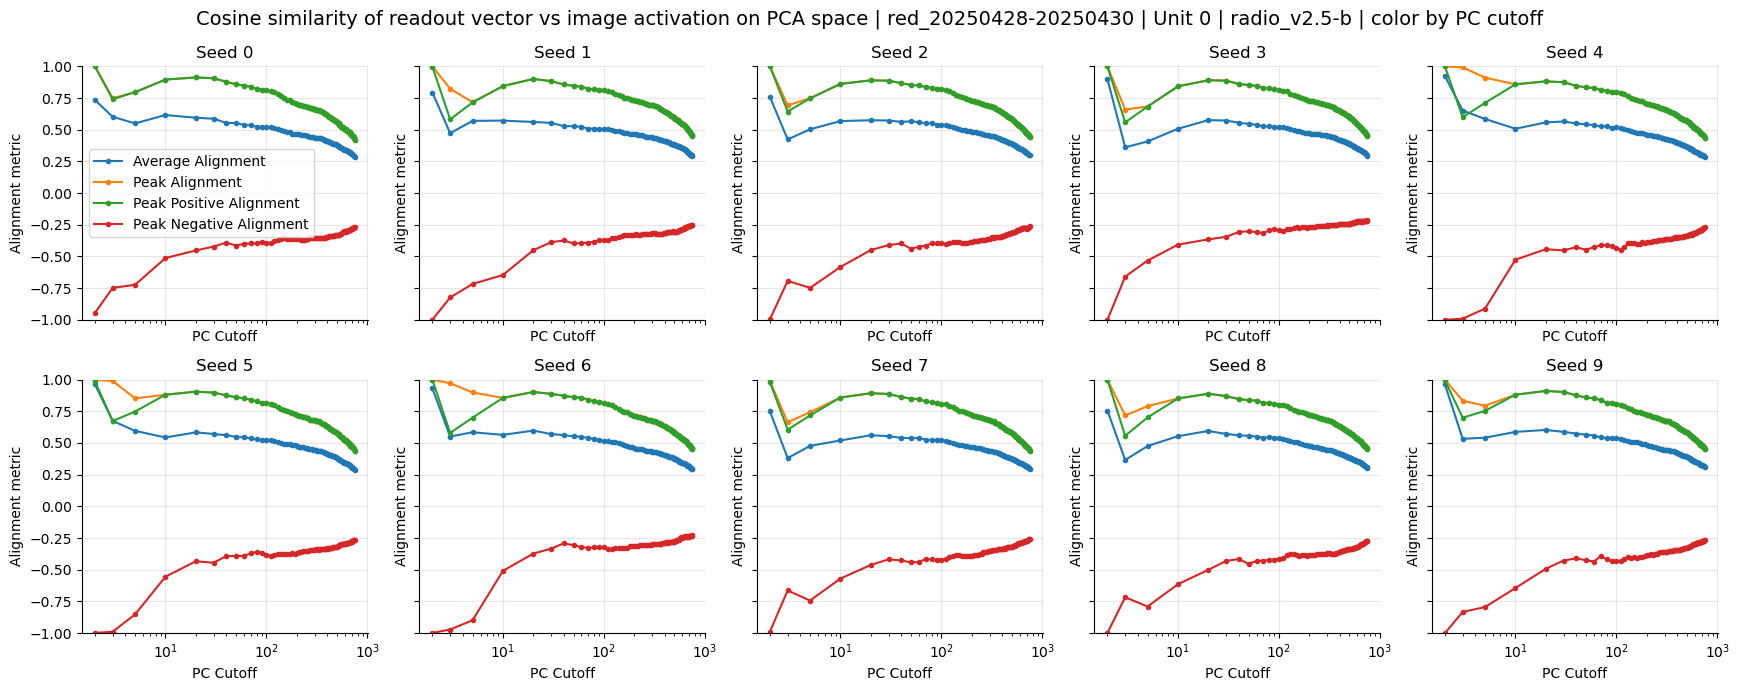

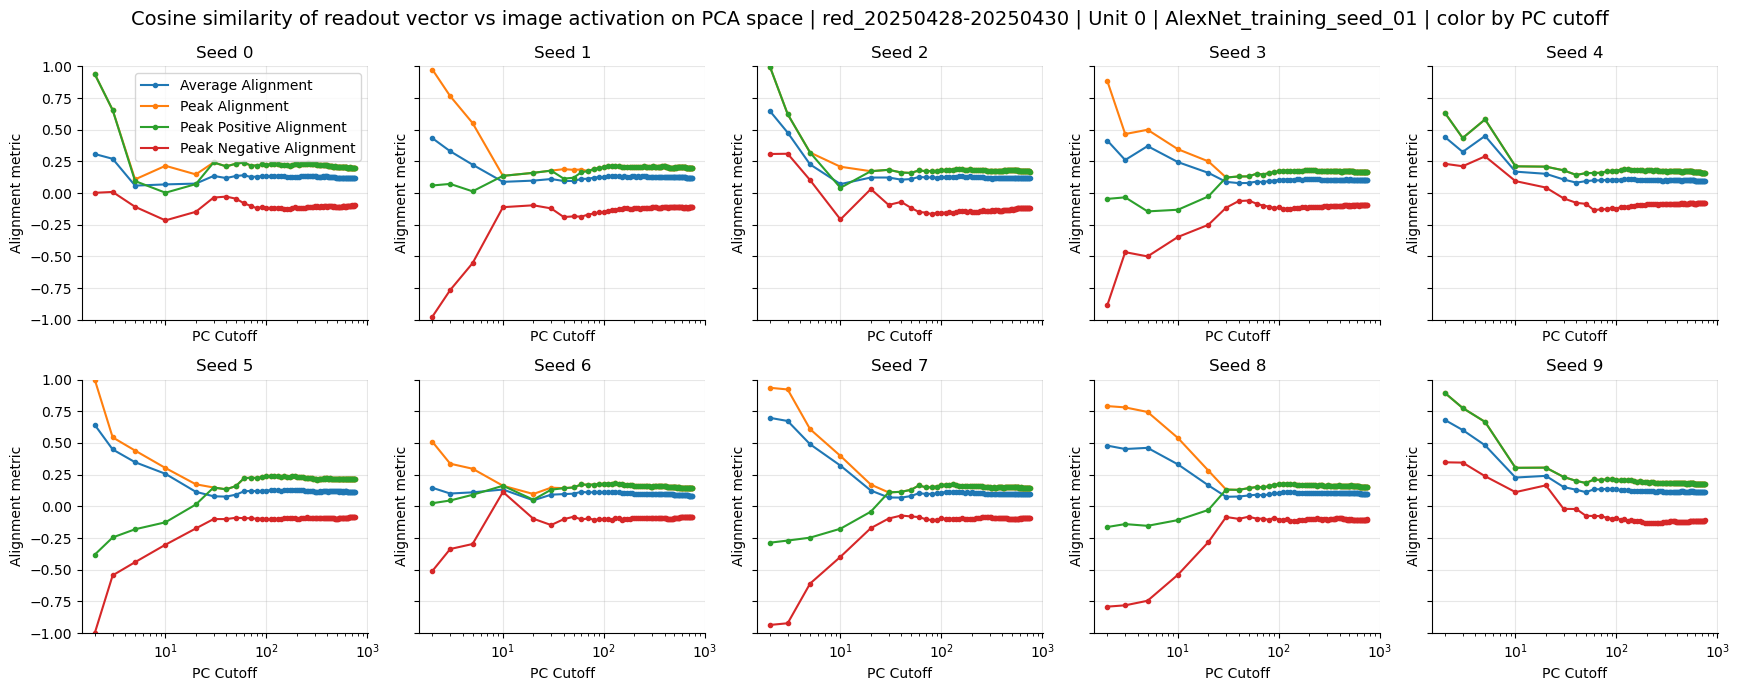

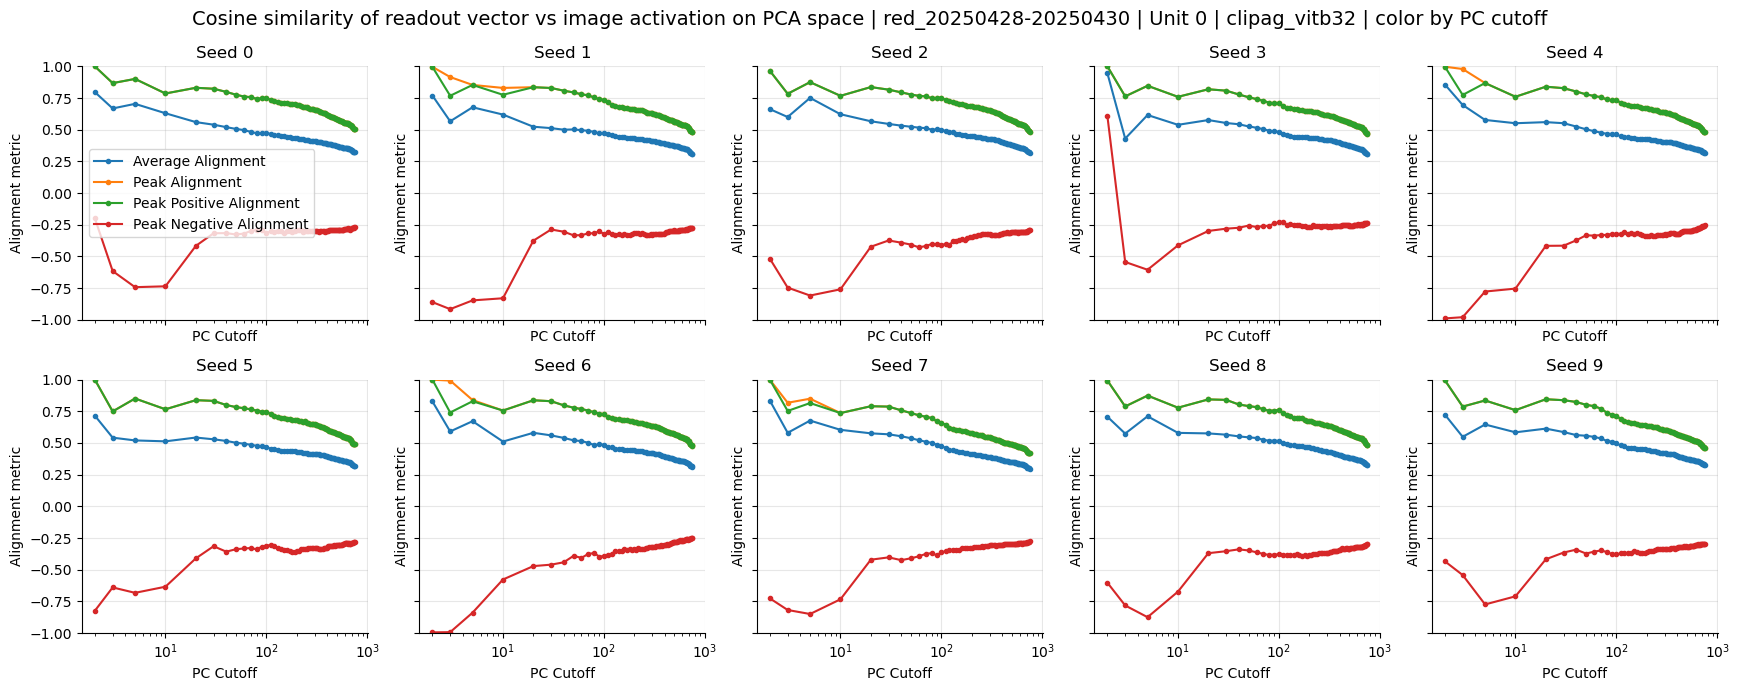

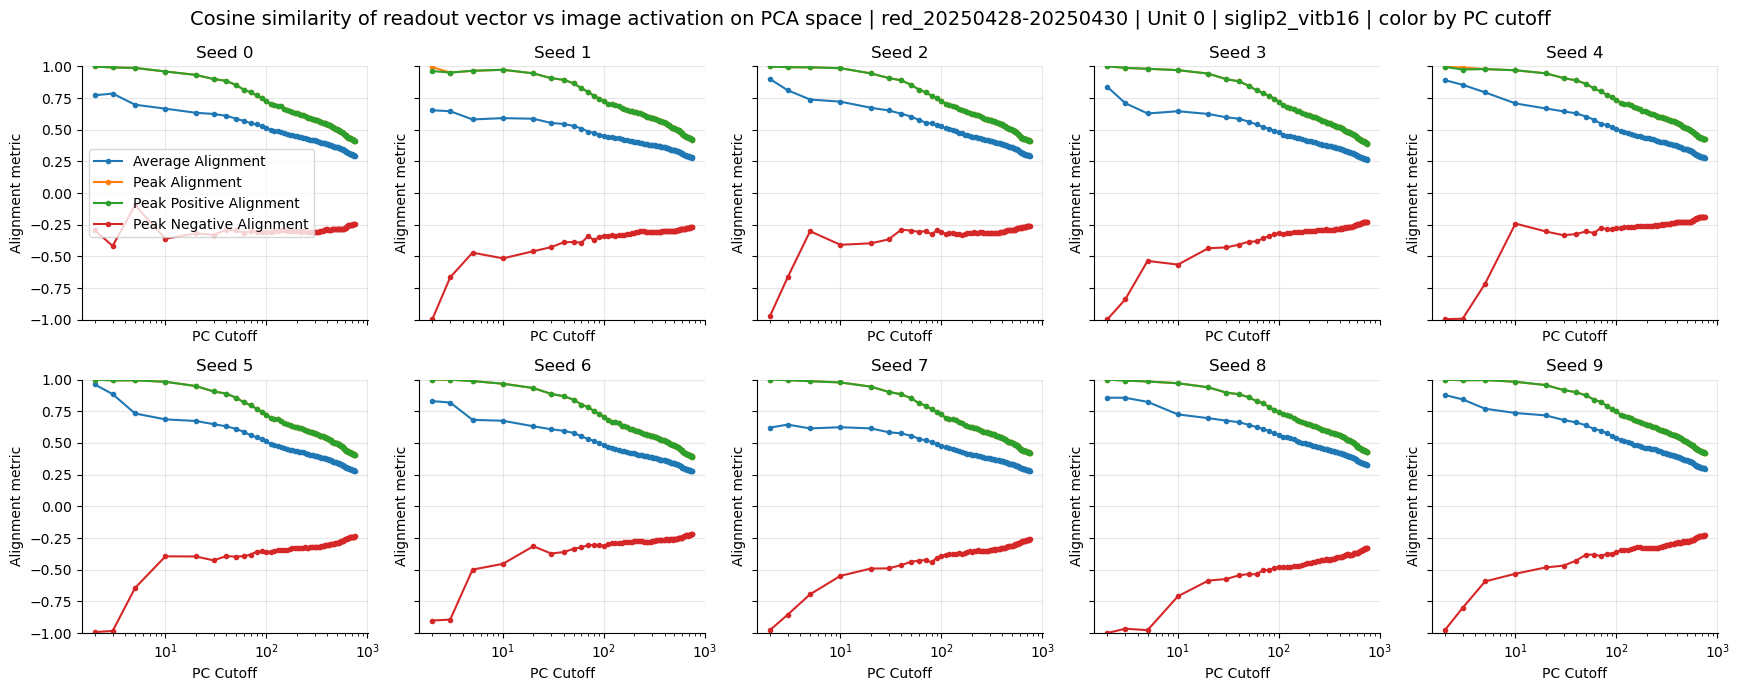

In [57]:
unit_id = 0
for model_name in model_names:
    stats_dict = stats_dict_index[(model_name, unit_id)]
    df = stats_dict["df"]
    for pc_cutoff in pc_cutoffs:
        df[f"cosine_similarity_{pc_cutoff}"] = cosine_results[(model_name, unit_id, pc_cutoff)]
    # Get unique img_ids for creating subplots
    img_ids = df.query("model_name == @model_name and unit_id == @unit_id")["img_id"].unique()
    n_imgs = len(img_ids)
    nrows = 2
    ncols = n_imgs // nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.5*nrows), sharey=True, sharex=True)
    axes = axes.flatten()
    for i, img_id in enumerate(img_ids):
        acc_unit_df = df.query("model_name == @model_name and unit_id == @unit_id and img_id == @img_id")
        alignment_df = compute_alignment_metrics(acc_unit_df)
        for metric, title in zip(metrics, titles):
            axes[i].plot(alignment_df['pc_cutoff'], alignment_df[metric], marker='o', linewidth=1.5, markersize=3, label=title)
            axes[i].set_xlabel('PC Cutoff')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xscale('log')
            if i == 0:
                axes[i].legend()
        axes[i].set_ylim(-1, 1)
        axes[i].set_title(f"Seed {img_id}")
        axes[i].set_ylabel("Alignment metric")
    plt.suptitle(f"Cosine similarity of readout vector vs image activation on PCA space | {subject_id} | Unit {unit_id} | {model_name} | color by PC cutoff", fontsize=14)
    plt.tight_layout()
    plt.show()

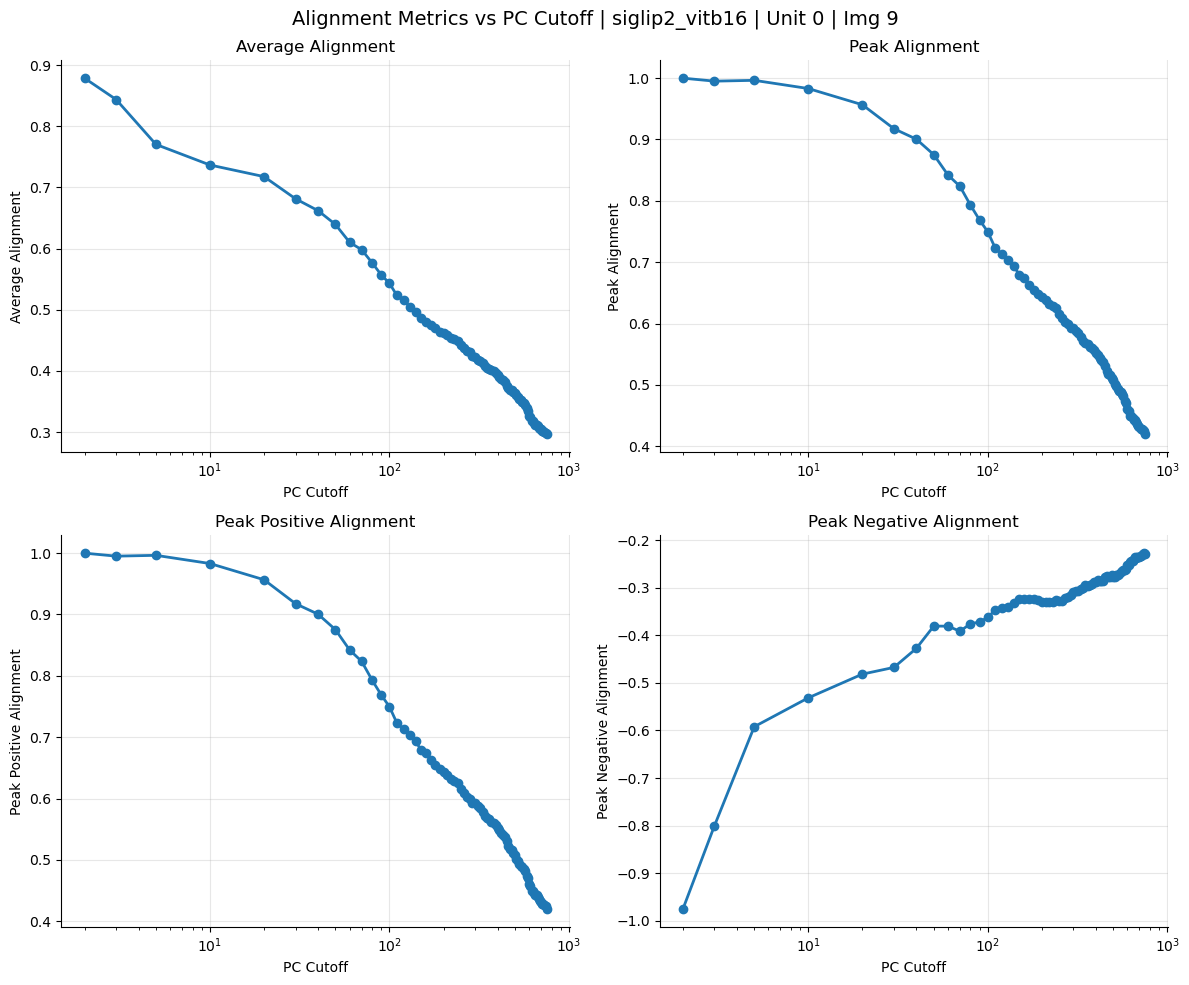

pc_cutoff  avg_alignment  peak_alignment  peak_pos_alignment  \
0           2       0.878538        0.999889            0.999889   
1           3       0.843599        0.994997            0.994997   
2           5       0.770196        0.996324            0.996324   
3          10       0.736552        0.982973            0.982973   
4          20       0.717574        0.956567            0.956567   
..        ...            ...             ...                 ...   
73        710       0.301904        0.428867            0.428867   
74        720       0.301192        0.427897            0.427897   
75        730       0.300472        0.426768            0.426768   
76        740       0.299183        0.424908            0.424908   
77        750       0.296318        0.419583            0.419583   

    peak_neg_alignment  
0            -0.975867  
1            -0.800451  
2            -0.592168  
3            -0.531507  
4            -0.481690  
..                 ...  
73           -0.234465  
74           -0.231028  
75           -0.230288  
76           -0.227435  
77           -0.229200  

[78 rows x 5 columns]

In [51]:
# Plot alignment metrics as function of PC cutoff
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ['avg_alignment', 'peak_alignment', 'peak_pos_alignment', 'peak_neg_alignment']
titles = ['Average Alignment', 'Peak Alignment', 'Peak Positive Alignment', 'Peak Negative Alignment']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    axes[i].plot(alignment_df['pc_cutoff'], alignment_df[metric], marker='o', linewidth=2, markersize=6)
    axes[i].set_xlabel('PC Cutoff')
    axes[i].set_ylabel(title)
    axes[i].set_title(title)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xscale('log')

plt.suptitle(f'Alignment Metrics vs PC Cutoff | {model_name} | Unit {unit_id} | Img {img_id}', fontsize=14)
plt.tight_layout()
plt.show()

alignment_df

In [ ]:
# Create a multi-panel plot with 5 rows (units) and 10 columns (models)
fig, axes = plt.subplots(5, 10, figsize=(20, 12), sharex=True, sharey=True)
for subject_id, filename in [
    ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("three0_250426-250501", "three0_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("leap_250426-250501", "leap_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
]:
    posthoc_PCA_dir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/{subject_id}/posthoc_model_predict_PCA_popul_unit"
    all_pkl_files = glob.glob(join(posthoc_PCA_dir, "posthoc_prediction_PCA_pop_unit_*.pkl"))
    # Get unique model names and unit IDs for indexing
    model_names = []
    unit_ids = []
    for pkl_file in all_pkl_files:
        stats_dict = pkl.load(open(pkl_file, "rb"))
        model_name = stats_dict["config"]["model_name"]
        unit_id = stats_dict["config"]["unit_ids"][0]
        if model_name not in model_names:
            model_names.append(model_name)
        if unit_id not in unit_ids:
            unit_ids.append(unit_id)
    
    for pkl_file in all_pkl_files:
        stats_dict = pkl.load(open(pkl_file, "rb"))
        model_name = stats_dict["config"]["model_name"]
        unit_id = stats_dict["config"]["unit_ids"][0]
        acc_unit_df = stats_dict["df"].query("model_name == @model_name and unit_id == @unit_id")
        # Find row and column indices
        row_idx = unit_ids.index(unit_id)
        col_idx = model_names.index(model_name)
        
        if row_idx < 5 and col_idx < 10:
            sns.lineplot(x="score", y="cosine_similarity", data=acc_unit_df, hue="img_id", 
                        palette="tab10", markers=True, ax=axes[row_idx, col_idx], legend=False)
            axes[row_idx, col_idx].set_title(f"{model_name}\nUnit {unit_id}", fontsize=8)
            axes[row_idx, col_idx].set_xlabel("Score", fontsize=8)
            axes[row_idx, col_idx].set_ylabel("Cosine Similarity", fontsize=8)

# Hide any unused subplots
for row in range(5):
    for col in range(10):
        if not axes[row, col].has_data():
            axes[row, col].set_visible(False)

plt.suptitle(f"Cosine similarity of readout vector vs image activation on PCA space | {subject_id} | color by seed id", fontsize=14)
plt.tight_layout()
plt.show()